# Pre-Processing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, LassoCV, LassoLarsCV
from sklearn import svm, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

scale = StandardScaler()

/kaggle/input/full-canola-features/almost_final_final_df.csv


2024-03-14 14:22:44.637317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 14:22:44.637479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 14:22:44.781095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
canola_feats = pd.read_csv('/kaggle/input/full-canola-features/almost_final_final_df.csv', index_col=0)
canola_features = canola_feats.drop(columns=['Region'])

In [3]:
canola_features.rename(columns={'Soil Zone': 'soil_zone'}, inplace=True)

columns = canola_features.columns.tolist()

columns[1], columns[2] = columns[2], columns[1]
columns[24], columns[25] = columns[25], columns[24]

canola_features['region'] = canola_features['region'].astype('category')
canola_features['soil_zone'] = canola_features['soil_zone'].astype('category')

canola_features = canola_features[columns]

canola_features.head(5)

Canola  average_max_temp_in_4 region  average_max_temp_in_5  \
Year                                                                  
1990  0.127132             284.965759      1             290.526489   
1991  2.520378             287.648346      1             291.984650   
1992 -6.339489             283.242584      1             293.701874   
1993  4.147971             284.697113      1             292.762695   
1994  2.081733             285.144440      1             293.432678   

      average_max_temp_in_6  average_max_temp_in_7  average_max_temp_in_8  \
Year                                                                        
1990             297.082458             299.412781             300.752075   
1991             296.854401             297.652344             299.938751   
1992             295.445709             294.548126             297.033264   
1993             293.425385             294.037415             296.177429   
1994             294.774536             297.061951             297.072021   

      average_max_temp_in_9  average_max_temp_in_10  days_above_25  ...  \
Year                                                                ...   
1990             296.791382              286.036377             72  ...   
1991             292.543549              282.321960             51  ...   
1992             292.229004              285.503967             37  ...   
1993             291.031281              284.688232             26  ...   
1994             294.903839              286.052094             38  ...   

      SPI_in_5  SPI_in_6  SPI_in_7  SPI_in_8  SPI_in_9  SPI_in_10  soil_zone  \
Year                                                                           
1990  0.029108  0.115236  0.209242  0.256968  0.171961  -0.032910          1   
1991  0.331767  0.195163  0.282696  0.222439  0.398697   0.232995          1   
1992  0.193160 -0.188189  0.358708  0.309846  0.225539  -0.114548          1   
1993 -0.052129  0.086120  0.608185  0.263007  0.235375  -0.044934          1   
1994  0.114090  0.446020  0.102491  0.320304  0.034789   0.322164          1   

       Longitude   Latitude  region_aggregate  
Year                                           
1990 -101.479393  49.154052      Southeastern  
1991 -101.479393  49.154052      Southeastern  
1992 -101.479393  49.154052      Southeastern  
1993 -101.479393  49.154052      Southeastern  
1994 -101.479393  49.154052      Southeastern  

[5 rows x 27 columns]

In [4]:
feature_range = canola_features.describe().loc[['min', 'max']]
print(feature_range)

        Canola  average_max_temp_in_4  average_max_temp_in_5  \
min -28.589475             273.738098             283.846588   
max  37.225038             288.989288             296.168915   

     average_max_temp_in_6  average_max_temp_in_7  average_max_temp_in_8  \
min             288.912170             291.970642             290.063293   
max             300.128723             303.735107             302.568512   

     average_max_temp_in_9  average_max_temp_in_10  days_above_25  \
min             283.444427              274.645691            1.0   
max             298.978912              288.550812           95.0   

     days_under_0  ...  longest_cold_wave  SPI_in_4  SPI_in_5  SPI_in_6  \
min           0.0  ...                1.0 -0.489292 -0.541499 -0.467276   
max          25.0  ...               16.0  0.778780  0.821634  0.642283   

     SPI_in_7  SPI_in_8  SPI_in_9  SPI_in_10   Longitude   Latitude  
min -0.693923 -0.486054 -0.441822  -0.441540 -109.809488  49.134400  
max 

In [5]:
print(canola_features.info()) # Takeaways: 5973 values, no missing values, 27 columns (17 floats, 9 int, 1 obj), indexed by years (32y span)
canola_features.head()
print(canola_features.nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 5973 entries, 1990 to 2022
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Canola                      5973 non-null   float64 
 1   average_max_temp_in_4       5973 non-null   float64 
 2   region                      5973 non-null   category
 3   average_max_temp_in_5       5973 non-null   float64 
 4   average_max_temp_in_6       5973 non-null   float64 
 5   average_max_temp_in_7       5973 non-null   float64 
 6   average_max_temp_in_8       5973 non-null   float64 
 7   average_max_temp_in_9       5973 non-null   float64 
 8   average_max_temp_in_10      5973 non-null   float64 
 9   days_above_25               5973 non-null   int64   
 10  days_under_0                5973 non-null   int64   
 11  longest_dry_spell           5973 non-null   int64   
 12  longest_wet_spell           5973 non-null   int64   
 13  days_over_95_precipi

In [6]:
canola_features

Canola  average_max_temp_in_4 region  average_max_temp_in_5  \
Year                                                                   
1990   0.127132             284.965759      1             290.526489   
1991   2.520378             287.648346      1             291.984650   
1992  -6.339489             283.242584      1             293.701874   
1993   4.147971             284.697113      1             292.762695   
1994   2.081733             285.144440      1             293.432678   
...         ...                    ...    ...                    ...   
2018  -0.642088             277.338013    622             294.617126   
2019   5.176214             283.511230    622             289.193604   
2020  -1.002221             277.344818    622             290.024719   
2021 -18.980060             284.660583    622             290.581299   
2022   0.548040             279.618134    622             289.977875   

      average_max_temp_in_6  average_max_temp_in_7  average_max_temp_in_8  \
Year                                                                        
1990             297.082458             299.412781             300.752075   
1991             296.854401             297.652344             299.938751   
1992             295.445709             294.548126             297.033264   
1993             293.425385             294.037415             296.177429   
1994             294.774536             297.061951             297.072021   
...                     ...                    ...                    ...   
2018             296.039825             297.508179             297.946716   
2019             293.939178             295.673492             293.541107   
2020             293.347931             296.085846             296.669983   
2021             297.739471             299.774323             298.133942   
2022             294.012695             296.951447             298.845917   

      average_max_temp_in_9  average_max_temp_in_10  days_above_25  ...  \
Year                                                                ...   
1990             296.791382              286.036377             72  ...   
1991             292.543549              282.321960             51  ...   
1992             292.229004              285.503967             37  ...   
1993             291.031281              284.688232             26  ...   
1994             294.903839              286.052094             38  ...   
...                     ...                     ...            ...  ...   
2018             285.104767              280.153503             51  ...   
2019             289.933136              280.083069             11  ...   
2020             291.383881              279.867188             23  ...   
2021             293.659637              284.803772             55  ...   
2022             295.413269              287.941833             41  ...   

      SPI_in_5  SPI_in_6  SPI_in_7  SPI_in_8  SPI_in_9  SPI_in_10  soil_zone  \
Year                                                                           
1990  0.029108  0.115236  0.209242  0.256968  0.171961  -0.032910          1   
1991  0.331767  0.195163  0.282696  0.222439  0.398697   0.232995          1   
1992  0.193160 -0.188189  0.358708  0.309846  0.225539  -0.114548          1   
1993 -0.052129  0.086120  0.608185  0.263007  0.235375  -0.044934          1   
1994  0.114090  0.446020  0.102491  0.320304  0.034789   0.322164          1   
...        ...       ...       ...       ...       ...        ...        ...   
2018  0.071520 -0.122097  0.151804  0.051411  0.736179   0.064329          1   
2019 -0.011202  0.415322  0.431917  0.398095  0.342884   0.266801          1   
2020  0.199944  0.051762  0.370352 -0.142280  0.154249   0.130587          1   
2021  0.136880 -0.346204 -0.245956  0.046748 -0.020174  -0.309495          1   
2022  0.204122 -0.051296  0.081554 -0.135292  0.020000  -0.261379          1   

       Longitude   Latitude  region_aggregate  
Year 

### Target Variable Analysis

/tmp/ipykernel_34/3634854611.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(x='Canola', data=canola_features, fill=True, palette='viridis')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


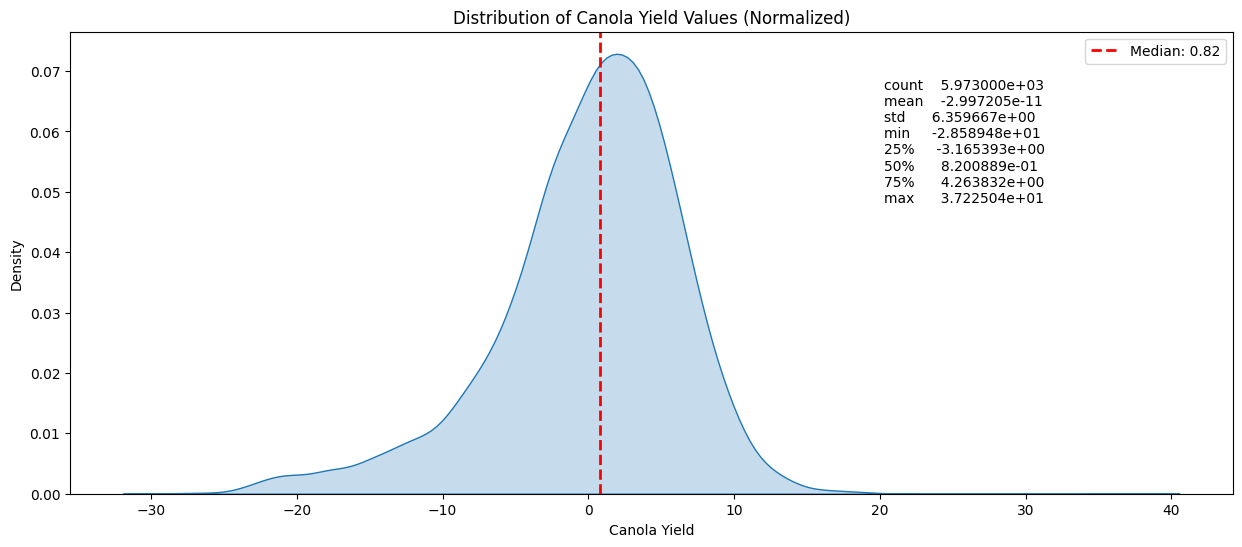

0.8200888737174097


In [7]:
plt.figure(figsize=(15, 6))
sns.kdeplot(x='Canola', data=canola_features, fill=True, palette='viridis')

median_value = canola_features['Canola'].median()
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.text(0.7, 0.9, canola_features['Canola'].describe().to_string(), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel('Canola Yield')
plt.ylabel('Density')
plt.title('Distribution of Canola Yield Values (Normalized)')

plt.legend()

plt.show()

print(median_value)

### Feature Exploration

#### SPI Values

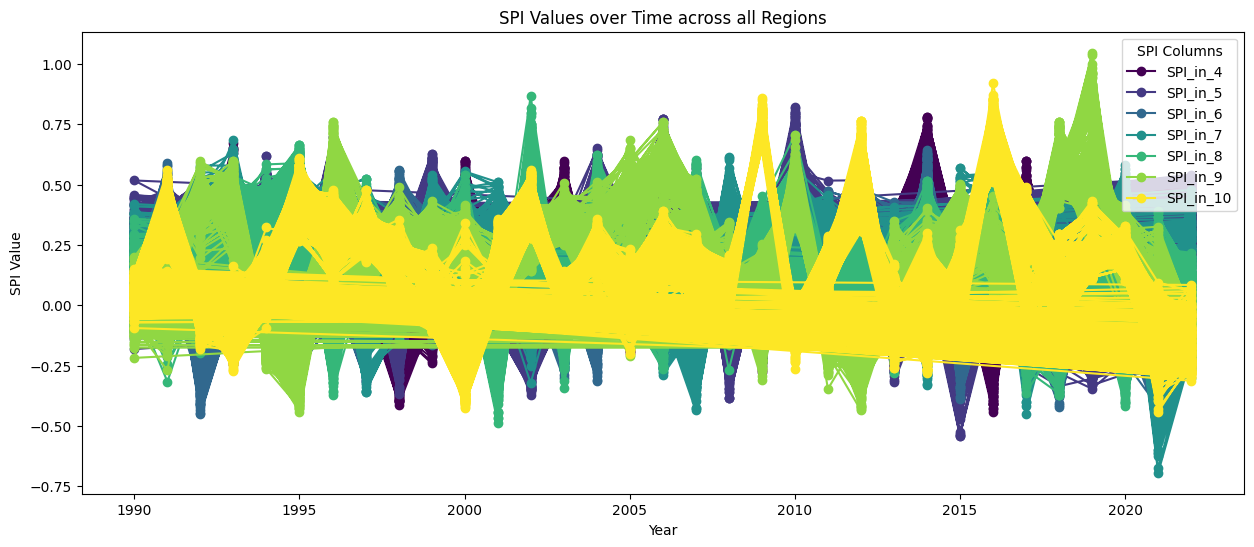

In [8]:
spi_columns = canola_features.filter(like='SPI_in')

spi_columns.plot(figsize=(15, 6), marker='o', colormap='viridis')

plt.xlabel('Year')
plt.ylabel('SPI Value')
plt.title('SPI Values over Time across all Regions')

plt.legend(title='SPI Columns')

plt.show()

#### Average Maximum Monthly Temperatures

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


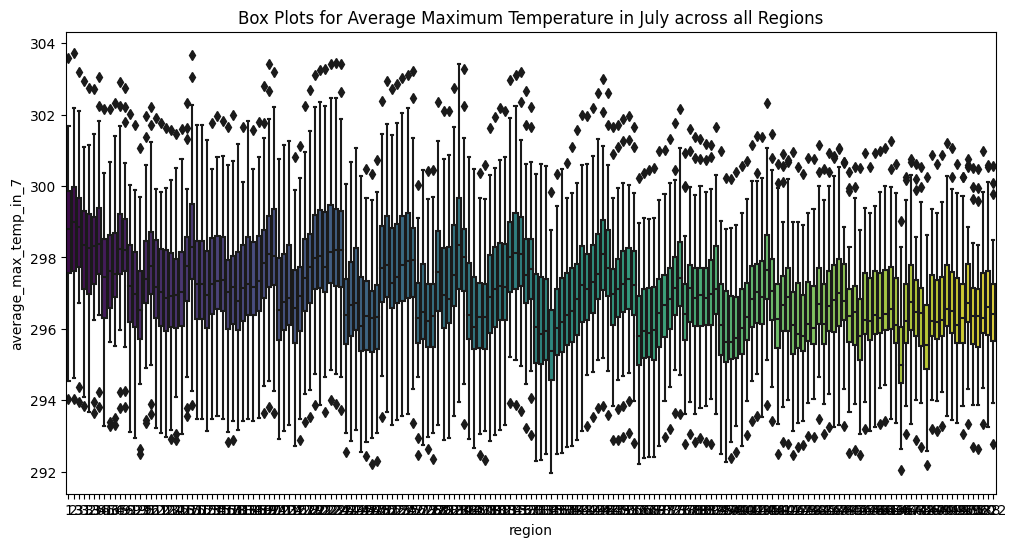

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='average_max_temp_in_7', data=canola_features, palette='viridis')
plt.title('Box Plots for Average Maximum Temperature in July across all Regions')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


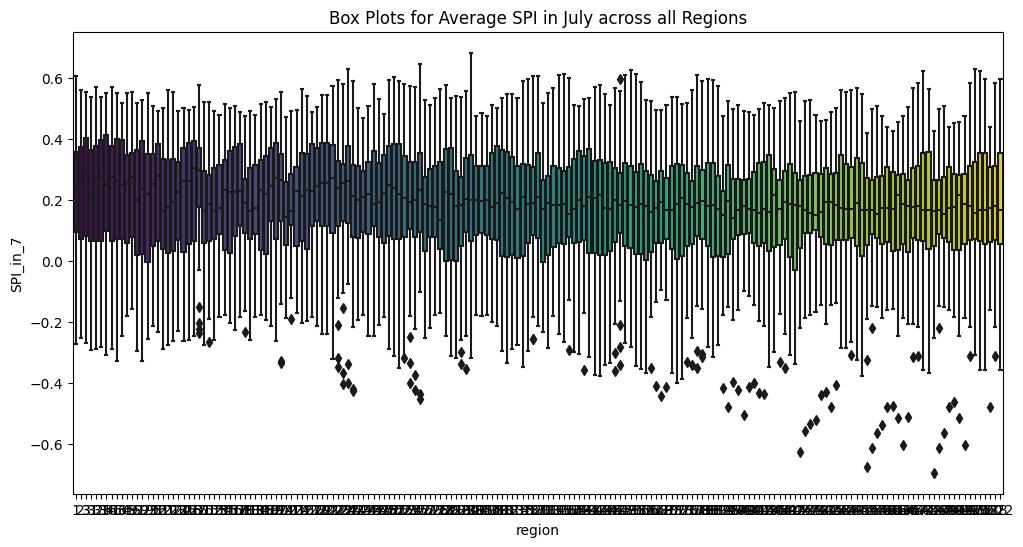

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='SPI_in_7', data=canola_features, palette='viridis')
plt.title('Box Plots for Average SPI in July across all Regions')
plt.show()

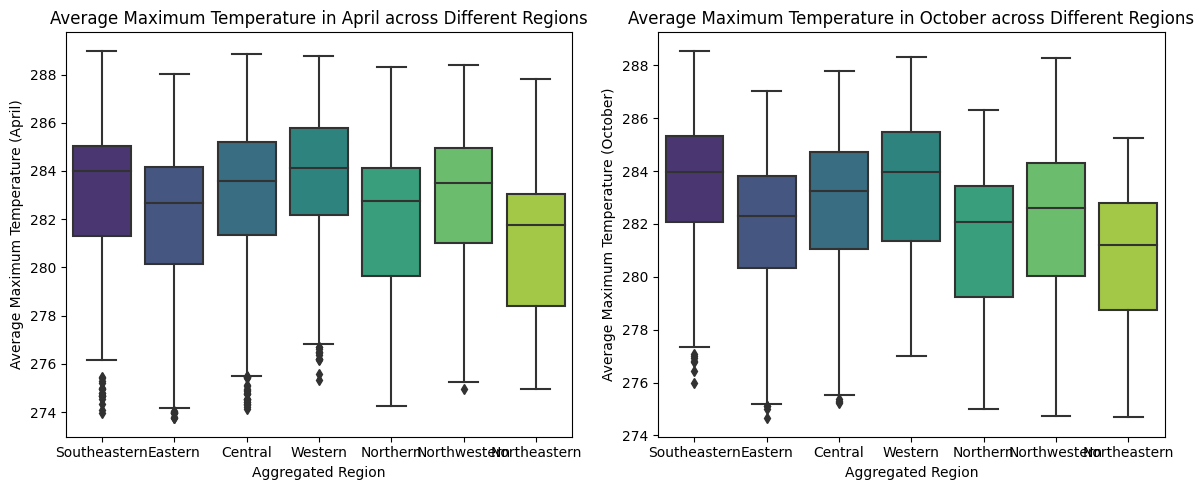

In [11]:
# Box Plots for Temperature Variables across Different Regions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='region_aggregate', y='average_max_temp_in_4', data=canola_features, palette='viridis')
plt.xlabel('Aggregated Region')
plt.ylabel('Average Maximum Temperature (April)')
plt.title('Average Maximum Temperature in April across Different Regions')

plt.subplot(1, 2, 2)
sns.boxplot(x='region_aggregate', y='average_max_temp_in_10', data=canola_features, palette='viridis')
plt.xlabel('Aggregated Region')
plt.ylabel('Average Maximum Temperature (October)')
plt.title('Average Maximum Temperature in October across Different Regions')

plt.tight_layout()
plt.show()

#### Heat and Frost Days

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

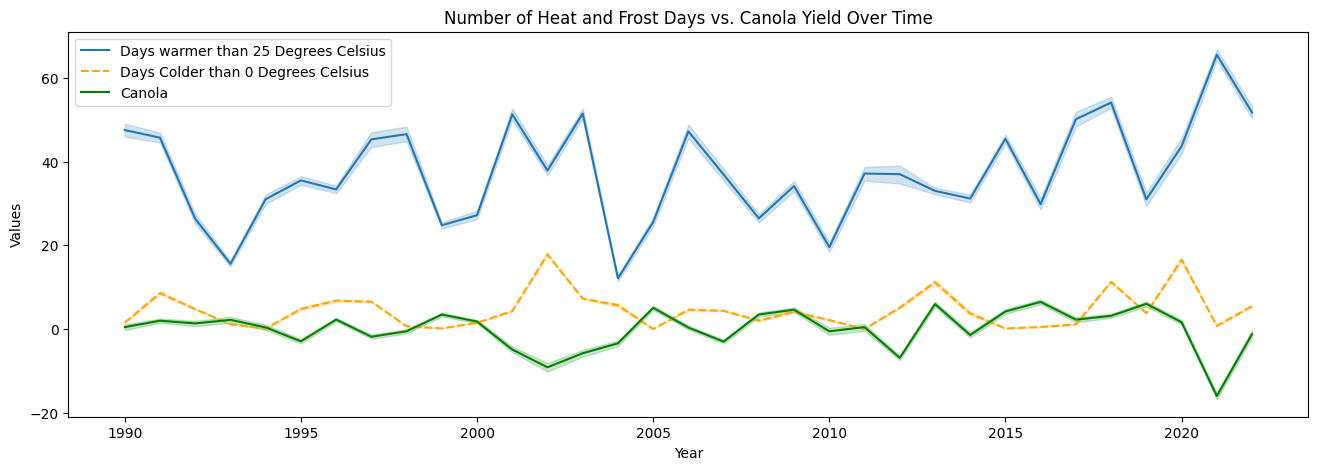

In [12]:
plt.figure(figsize=(16, 5))
sns.lineplot(x='Year', y='days_above_25', data=canola_features.reset_index(), label='Days warmer than 25 Degrees Celsius')
sns.lineplot(x='Year', y='days_under_0', data=canola_features.reset_index(), label='Days Colder than 0 Degrees Celsius', linestyle='--', color='orange')
sns.lineplot(x='Year', y='Canola', data=canola_features.reset_index(), label='Canola', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Number of Heat and Frost Days vs. Canola Yield Over Time')
plt.legend()
plt.show()

#### Soil Zone

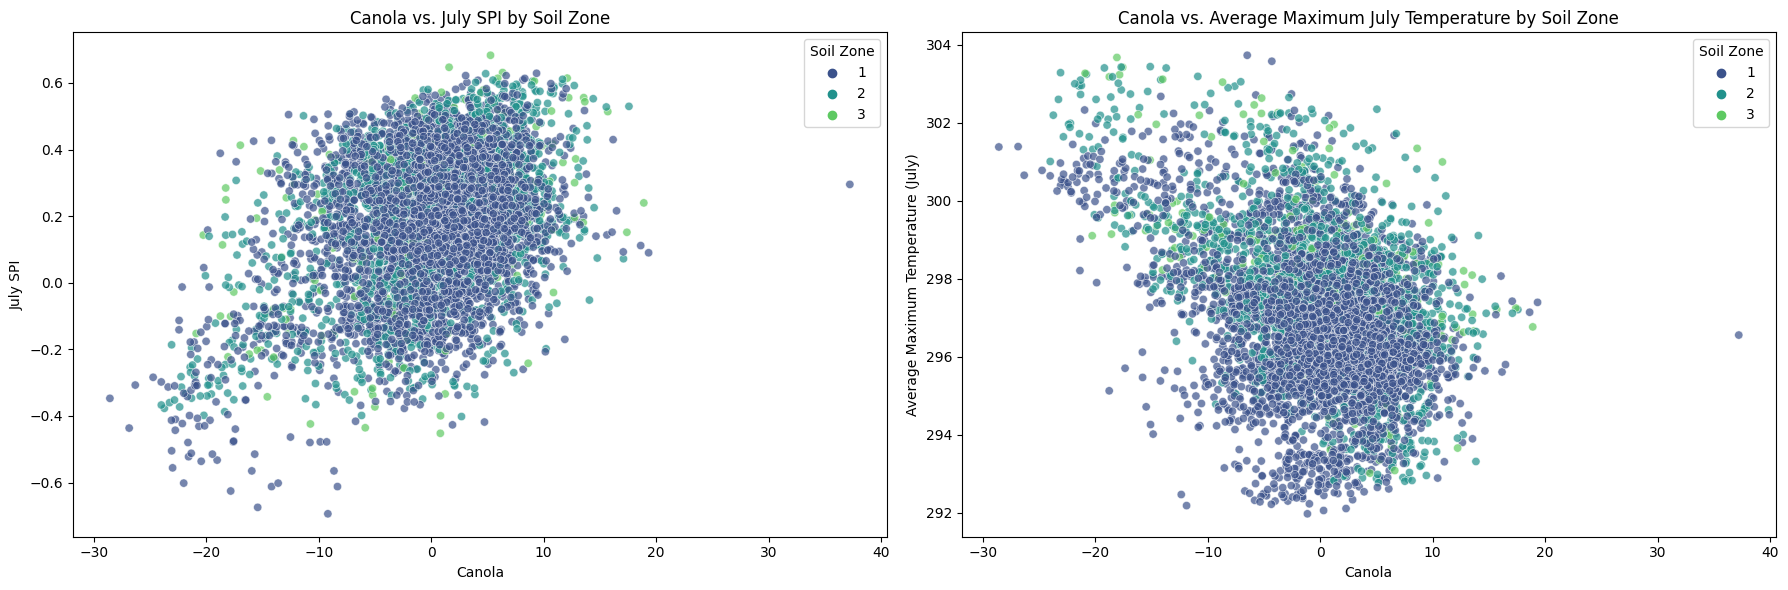

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(x='Canola', y='SPI_in_7', hue='soil_zone', data=canola_features, palette='viridis', alpha=0.7, ax=axs[0])
axs[0].set_xlabel('Canola')
axs[0].set_ylabel('July SPI')
axs[0].set_title('Canola vs. July SPI by Soil Zone')
axs[0].legend(title='Soil Zone')

sns.scatterplot(x='Canola', y='average_max_temp_in_7', hue='soil_zone', data=canola_features, palette='viridis', alpha=0.7, ax=axs[1])
axs[1].set_xlabel('Canola')
axs[1].set_ylabel('Average Maximum Temperature (July)')
axs[1].set_title('Canola vs. Average Maximum July Temperature by Soil Zone')
axs[1].legend(title='Soil Zone')

plt.tight_layout()
plt.show()

In [14]:
# outlier visible above

outlier_row = canola_features[canola_features['Canola'] > 30]
outlier_row

Canola  average_max_temp_in_4 region  average_max_temp_in_5  \
Year                                                                   
1994  37.225038             285.575378    499             291.458435   

      average_max_temp_in_6  average_max_temp_in_7  average_max_temp_in_8  \
Year                                                                        
1994             293.444427             296.556519             296.003845   

      average_max_temp_in_9  average_max_temp_in_10  days_above_25  ...  \
Year                                                                ...   
1994             295.027527              283.726349             35  ...   

      SPI_in_5  SPI_in_6  SPI_in_7  SPI_in_8  SPI_in_9  SPI_in_10  soil_zone  \
Year                                                                           
1994  0.432179  0.331947  0.295442  0.267108 -0.066986   0.003434          1   

       Longitude   Latitude  region_aggregate  
Year                                           
1994 -108.820647  53.507469      Northwestern  

[1 rows x 27 columns]

In [15]:
canola_features_no_outlier = canola_features[canola_features['Canola'] <= 30]

#### Soil Zone

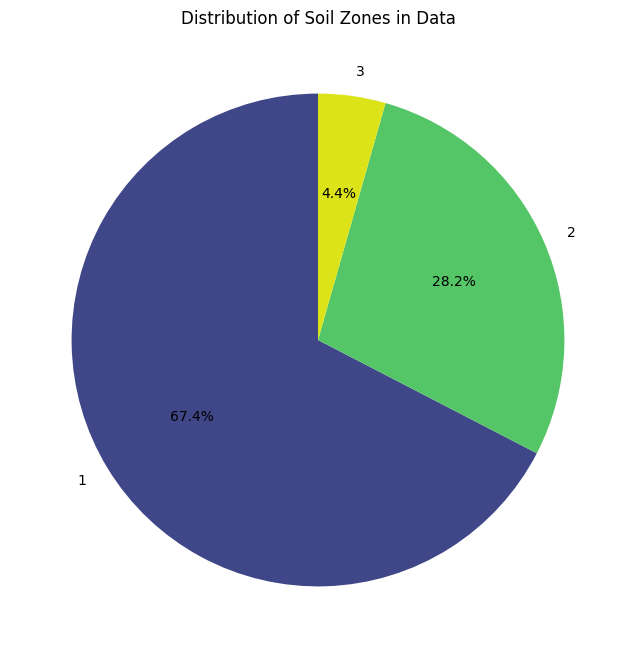

In [16]:
soil_zone_counts = canola_features_no_outlier['soil_zone'].value_counts()

colors = ['#404788FF', '#55C667FF', '#DCE319FF']

plt.figure(figsize=(8, 8))
plt.pie(soil_zone_counts, labels=soil_zone_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Soil Zones in Data')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


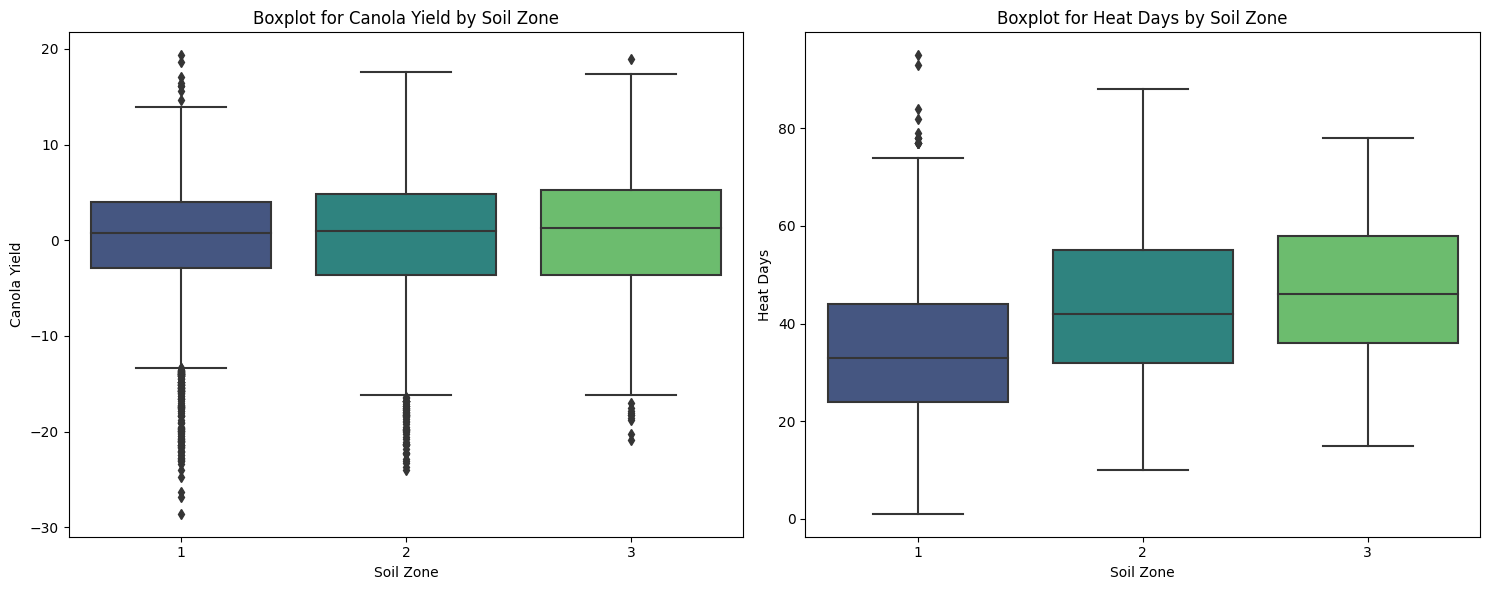

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='soil_zone', y='Canola', data=canola_features_no_outlier, palette='viridis', ax=axs[0])
axs[0].set_xlabel('Soil Zone')
axs[0].set_ylabel('Canola Yield')
axs[0].set_title('Boxplot for Canola Yield by Soil Zone')

sns.boxplot(x='soil_zone', y='days_above_25', data=canola_features_no_outlier.reset_index(), palette='viridis', ax=axs[1])
axs[1].set_xlabel('Soil Zone')
axs[1].set_ylabel('Heat Days')
axs[1].set_title('Boxplot for Heat Days by Soil Zone')

plt.tight_layout()
plt.show()

#### Latitude and Longitude

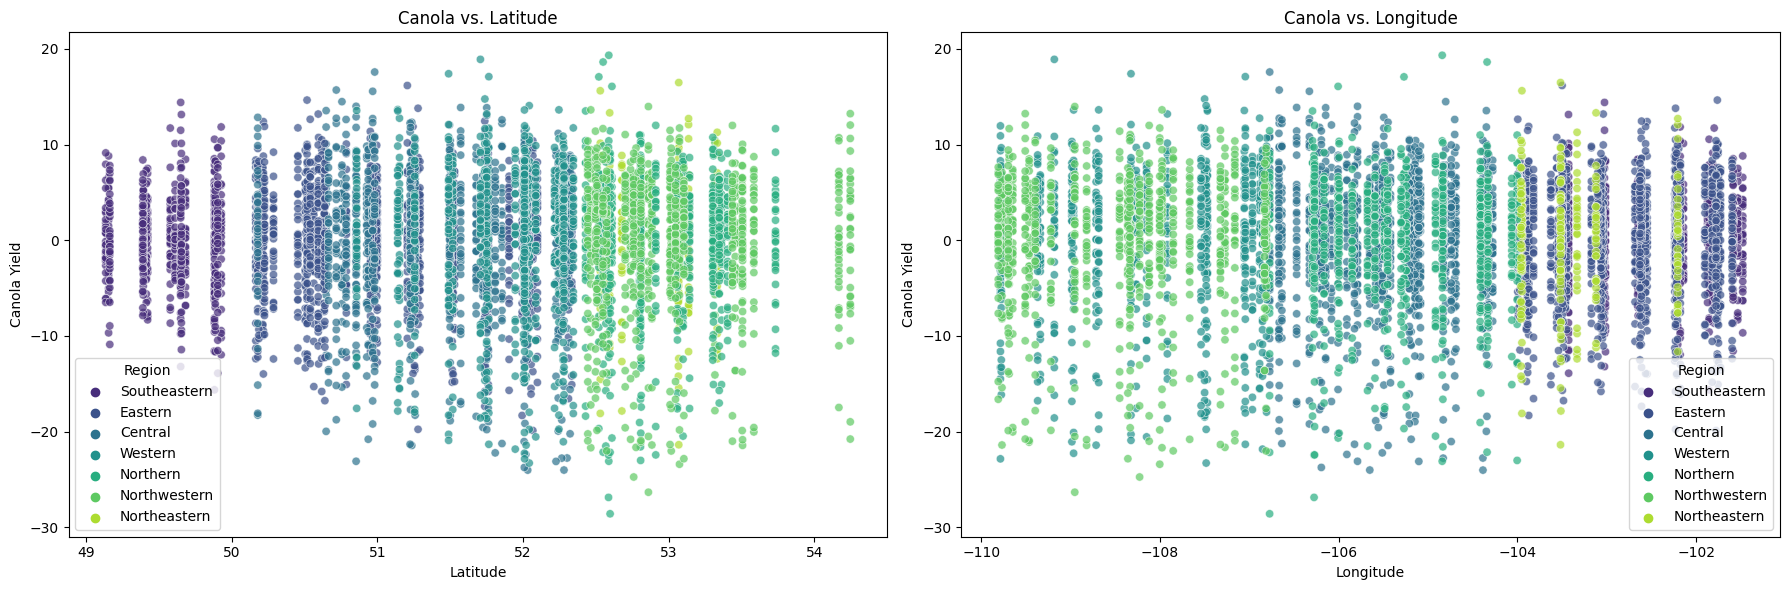

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(y='Canola', x='Latitude', hue='region_aggregate', data=canola_features_no_outlier, palette='viridis', alpha=0.7, ax=axs[0])
axs[0].set_ylabel('Canola Yield')
axs[0].set_xlabel('Latitude')
axs[0].set_title('Canola vs. Latitude')
axs[0].legend(title='Region')

sns.scatterplot(y='Canola', x='Longitude', hue='region_aggregate', data=canola_features_no_outlier, palette='viridis', alpha=0.7, ax=axs[1])
axs[1].set_ylabel('Canola Yield')
axs[1].set_xlabel('Longitude')
axs[1].set_title('Canola vs. Longitude')
axs[1].legend(title='Region')

plt.tight_layout()
plt.show()

#### Dry and Wet Spells

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

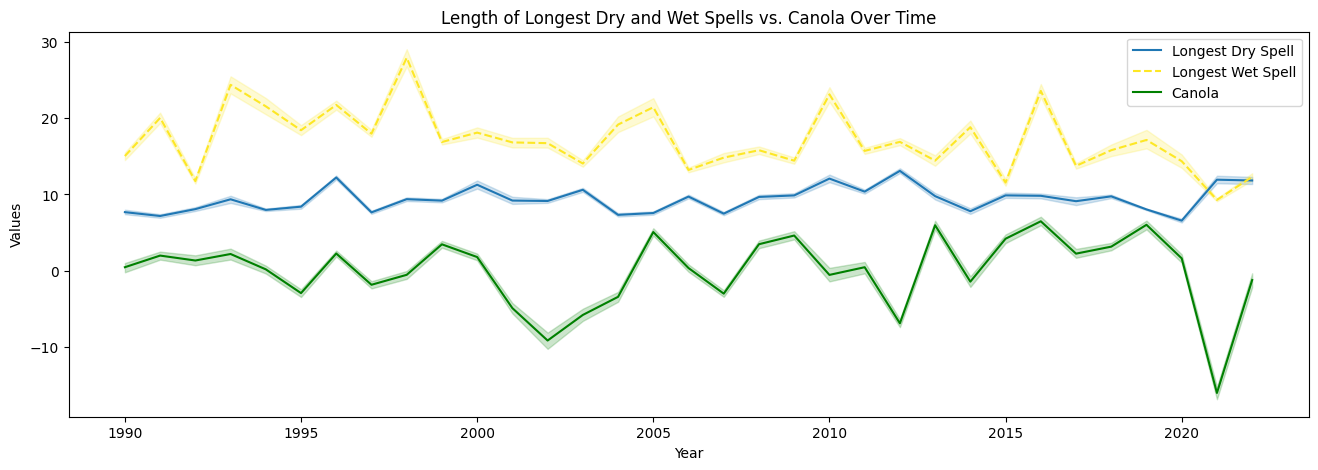

In [19]:
plt.figure(figsize=(16, 5))
sns.lineplot(x='Year', y='longest_dry_spell', data=canola_features_no_outlier.reset_index(), label='Longest Dry Spell')
sns.lineplot(x='Year', y='longest_wet_spell', data=canola_features_no_outlier.reset_index(), label='Longest Wet Spell', linestyle='--', color='#FDE725FF')
sns.lineplot(x='Year', y='Canola', data=canola_features_no_outlier.reset_index(), label='Canola', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Length of Longest Dry and Wet Spells vs. Canola Over Time')
plt.legend()
plt.show()

## Correlation Analysis

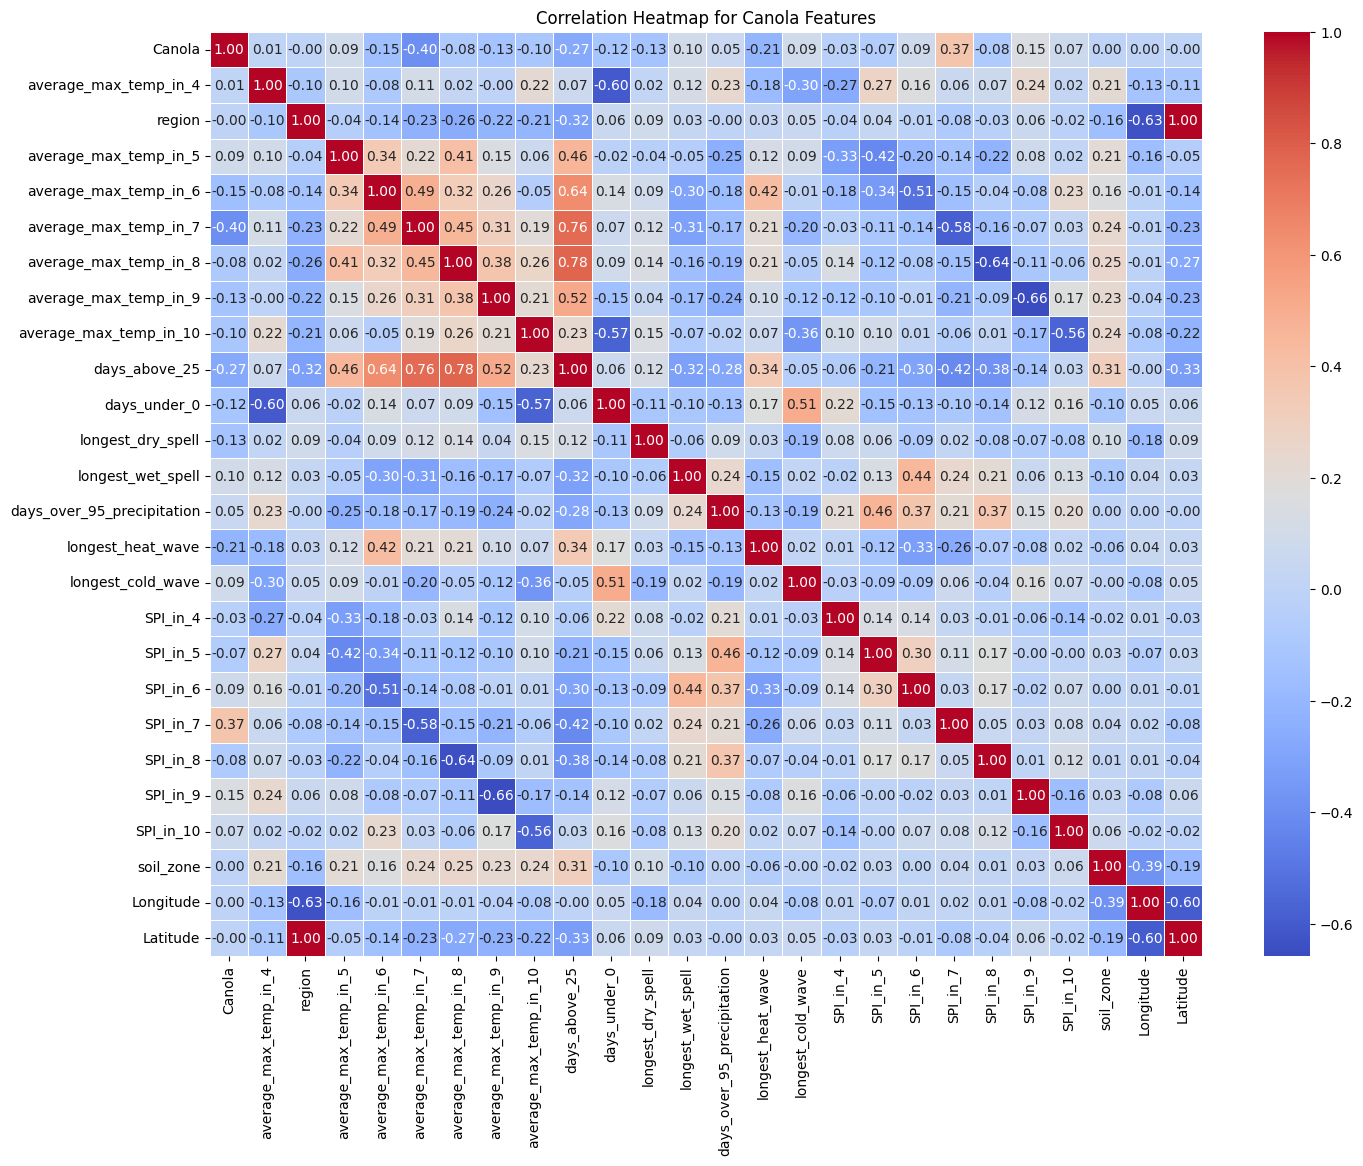

In [20]:
canola_subset = canola_features_no_outlier.drop('region_aggregate', axis=1)
plt.figure(figsize=(16, 12))
correlation_matrix = canola_subset.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Canola Features')
plt.show()

In [21]:
# TAKEAWAYS: region explained by lat and lon, avg_max_temp_8 explained by 7 and days >25 + no importance in LASSO, avg_max_temp_10 explained by days <0 and low importance in LASSO, wet days explained by SPIs and no importance in LASSO
canola_subsubset = canola_subset.drop(columns=['region', 'average_max_temp_in_6','average_max_temp_in_8', 'average_max_temp_in_10', 'days_over_95_precipitation'])

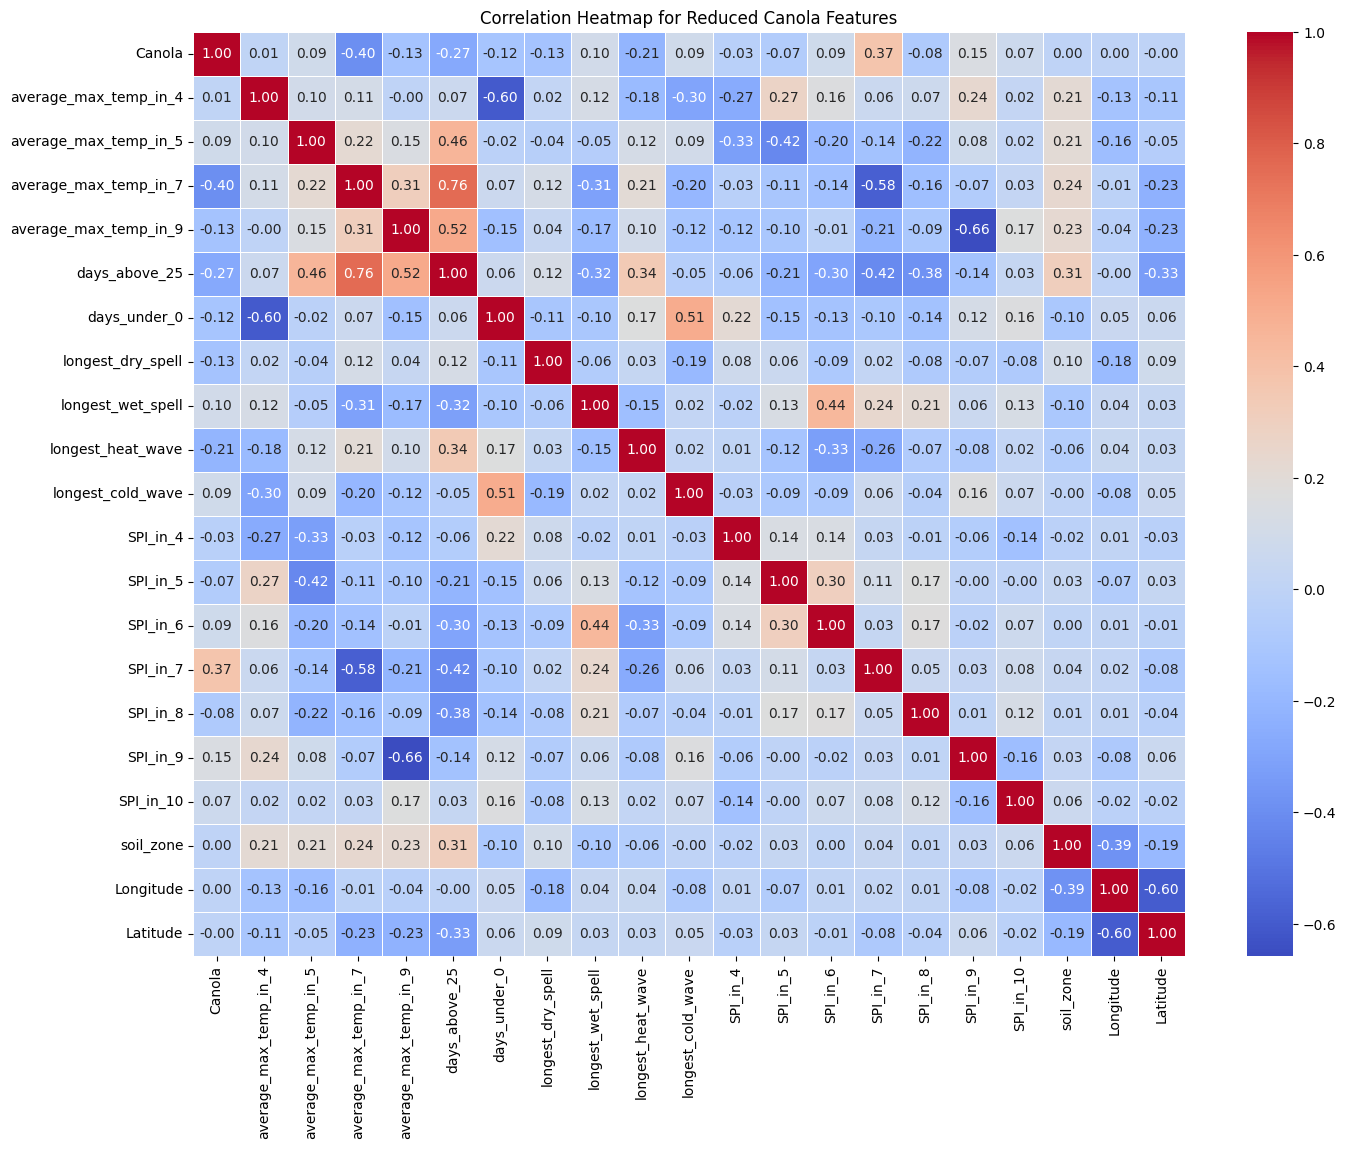

In [22]:
plt.figure(figsize=(16, 12))
correlation_matrix_2 = canola_subsubset.corr()
sns.heatmap(correlation_matrix_2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Reduced Canola Features')
plt.show()
# avg_max_temp_in_7 is critical but important in domain context and also in LASSO

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3

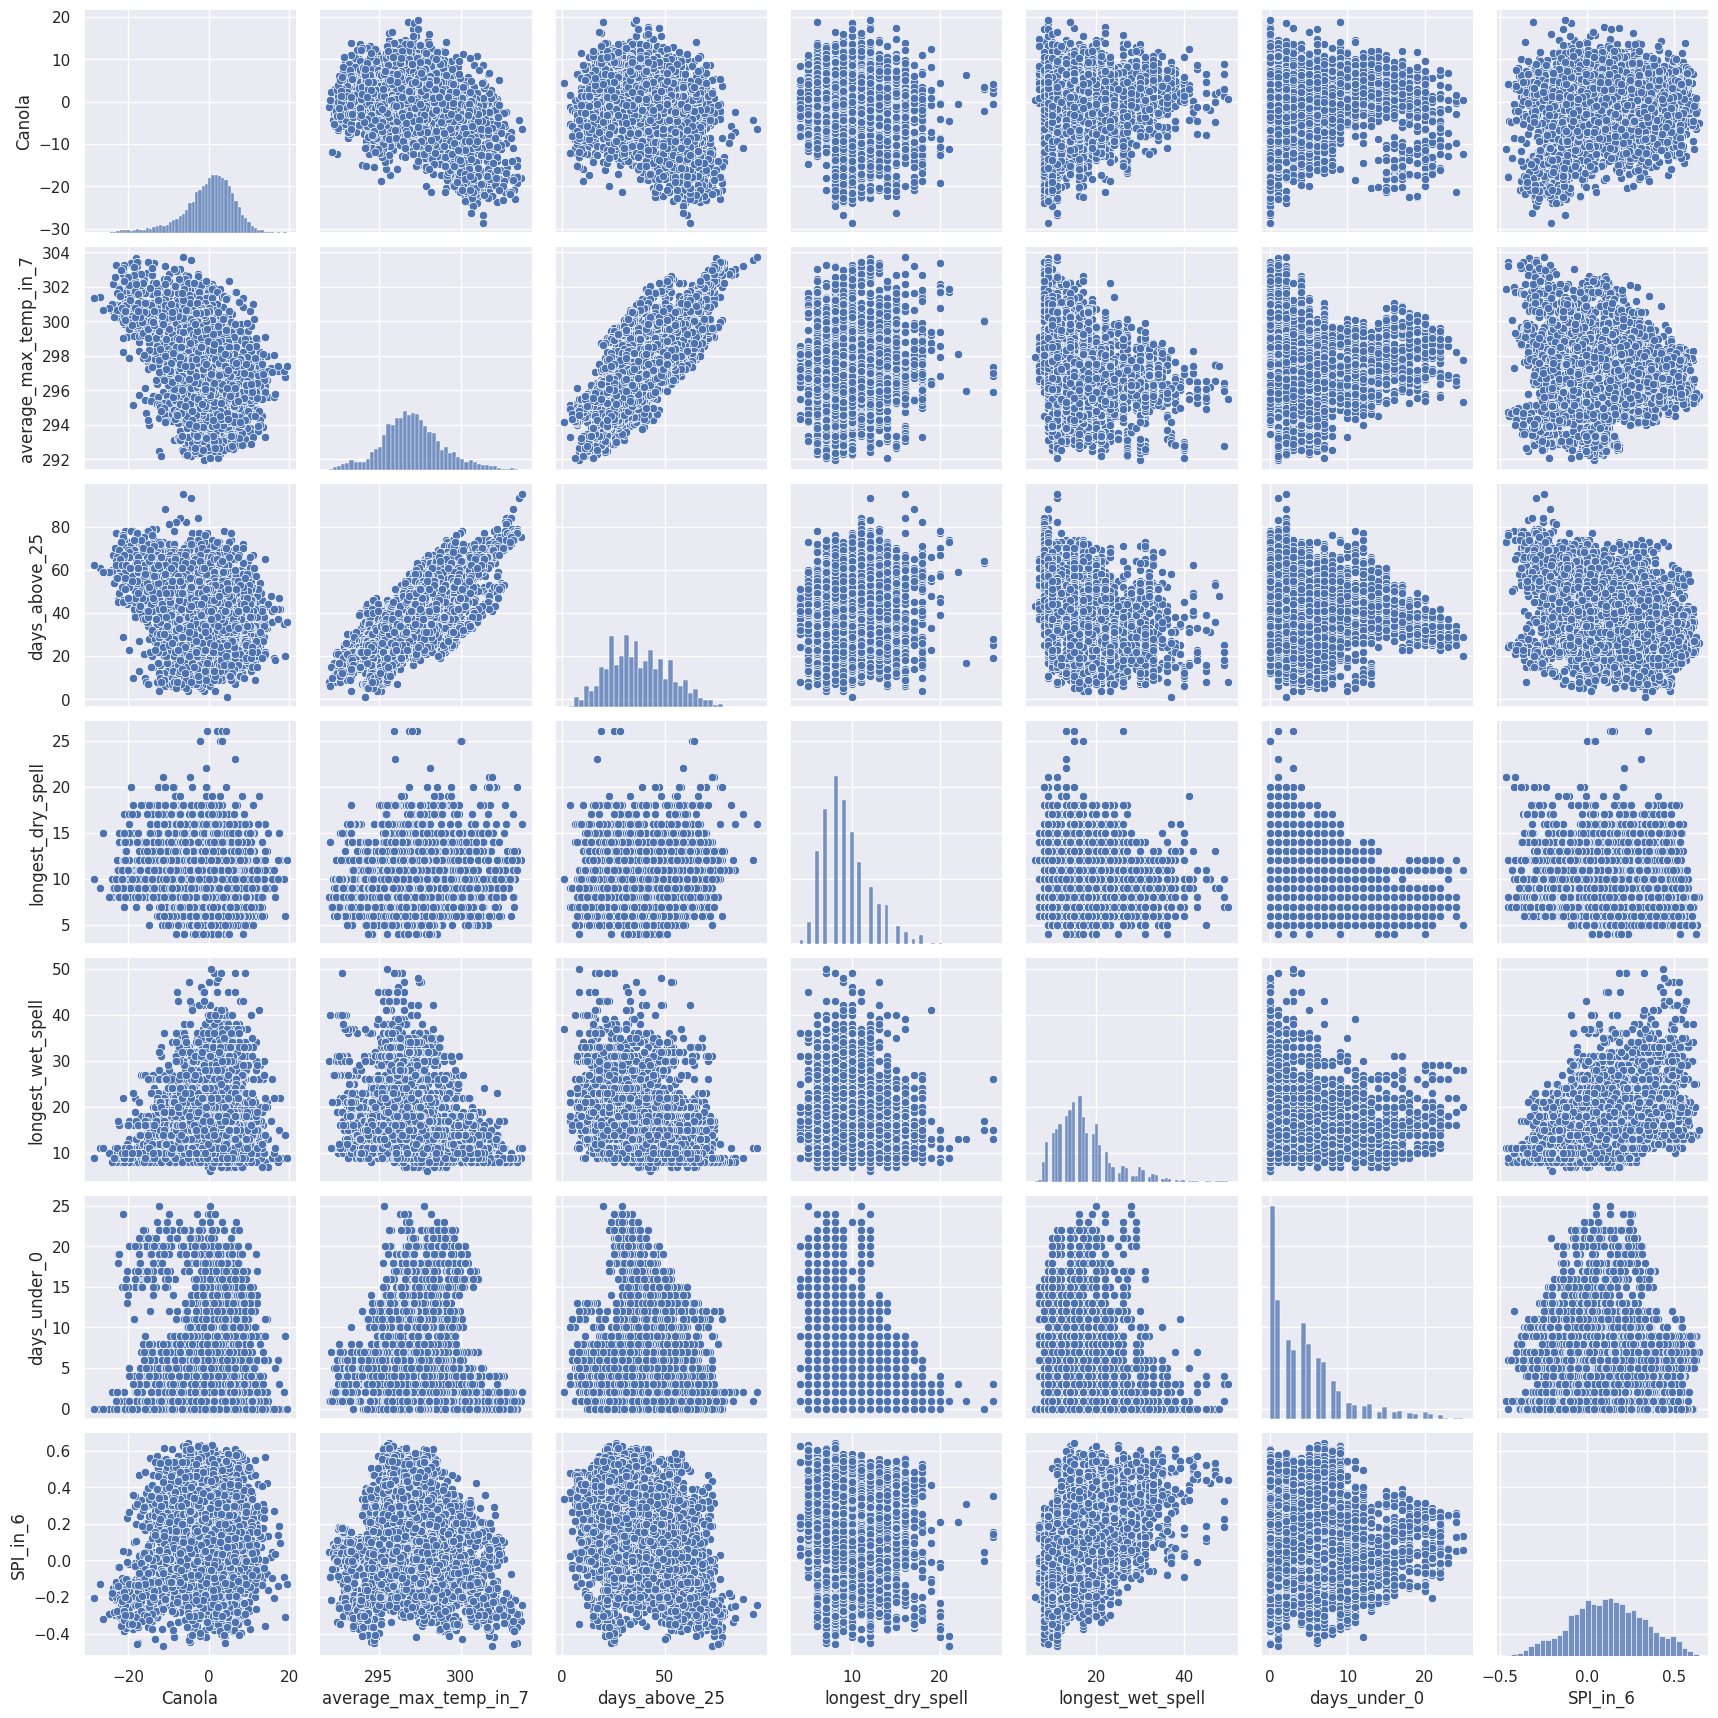

In [23]:
sns.set()
cols = ['Canola', 'average_max_temp_in_7', 'days_above_25', 'longest_dry_spell','longest_wet_spell', 'days_under_0','SPI_in_6']
sns.pairplot(canola_subsubset[cols], size = 2.5)
plt.show()

## Modelling (1): Feature Subset

#### Preparation

In [24]:
X = scale.fit_transform(canola_subsubset.reset_index().dropna())

In [25]:
canola_complete = canola_subsubset.dropna() 
X = canola_complete.drop(['Canola'], axis=1)
y = canola_complete['Canola']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Fundamental Regressions

In [27]:
classifiers = [
    LinearRegression(),
    Ridge(alpha=0.1),
    Lasso(alpha=0.02),
    ElasticNet(alpha=1.0, l1_ratio=0.5),
    svm.SVR(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.TheilSenRegressor()
]

for clf in classifiers:
    print(clf)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}\n")

LinearRegression()
Mean Squared Error: 27.150580627844043
R-squared: 0.31456017178011264

Ridge(alpha=0.1)
Mean Squared Error: 27.150578629141844
R-squared: 0.31456022223907376

Lasso(alpha=0.02)
Mean Squared Error: 27.17429866498471
R-squared: 0.3139613894731612

ElasticNet()
Mean Squared Error: 31.84627220117841
R-squared: 0.19601338747675745

SVR()
Mean Squared Error: 12.885705566268886
R-squared: 0.6746892476849122

BayesianRidge()
Mean Squared Error: 27.152660902597123
R-squared: 0.31450765344951237

LassoLars()
Mean Squared Error: 33.36721691969119
R-squared: 0.15761582608095437

ARDRegression()
Mean Squared Error: 27.168982142489536
R-squared: 0.31409560966961914

TheilSenRegressor()
Mean Squared Error: 27.873206793691182
R-squared: 0.29631685088120374



#### LASSO Regression

In [28]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)

lasso_coefs = lasso_model.coef_

y_pred_lasso = lasso_model.predict(X_test_scaled)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"LASSO - Mean Squared Error: {mse_lasso:.2f}")
print(f"LASSO - R-squared: {r2_lasso:.2f}")

LASSO - Mean Squared Error: 27.16
LASSO - R-squared: 0.31


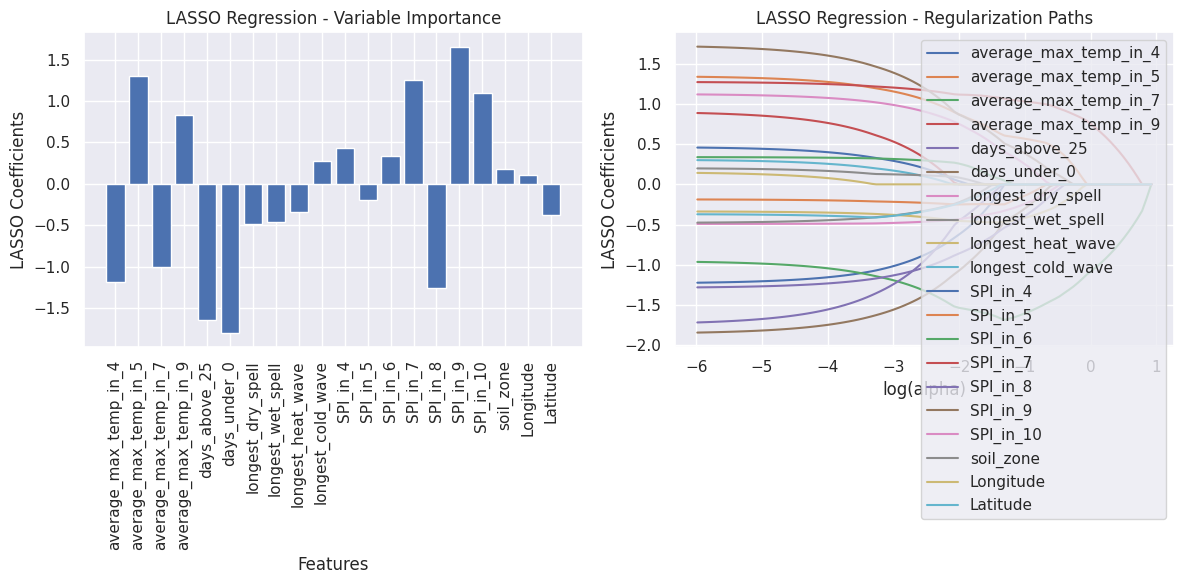

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(lasso_coefs)), lasso_coefs)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('LASSO Coefficients')
plt.title('LASSO Regression - Variable Importance')

plt.subplot(1, 2, 2)
alphas, coefs_lasso, _ = LassoCV(alphas=np.logspace(-6, 8, 13)).path(X_train_scaled, y_train)
lines = plt.plot(np.log(alphas), coefs_lasso.T)
plt.xlabel('log(alpha)')
plt.ylabel('LASSO Coefficients')
plt.title('LASSO Regression - Regularization Paths')
plt.legend(lines, X.columns, loc='upper right')

plt.tight_layout()
plt.show()

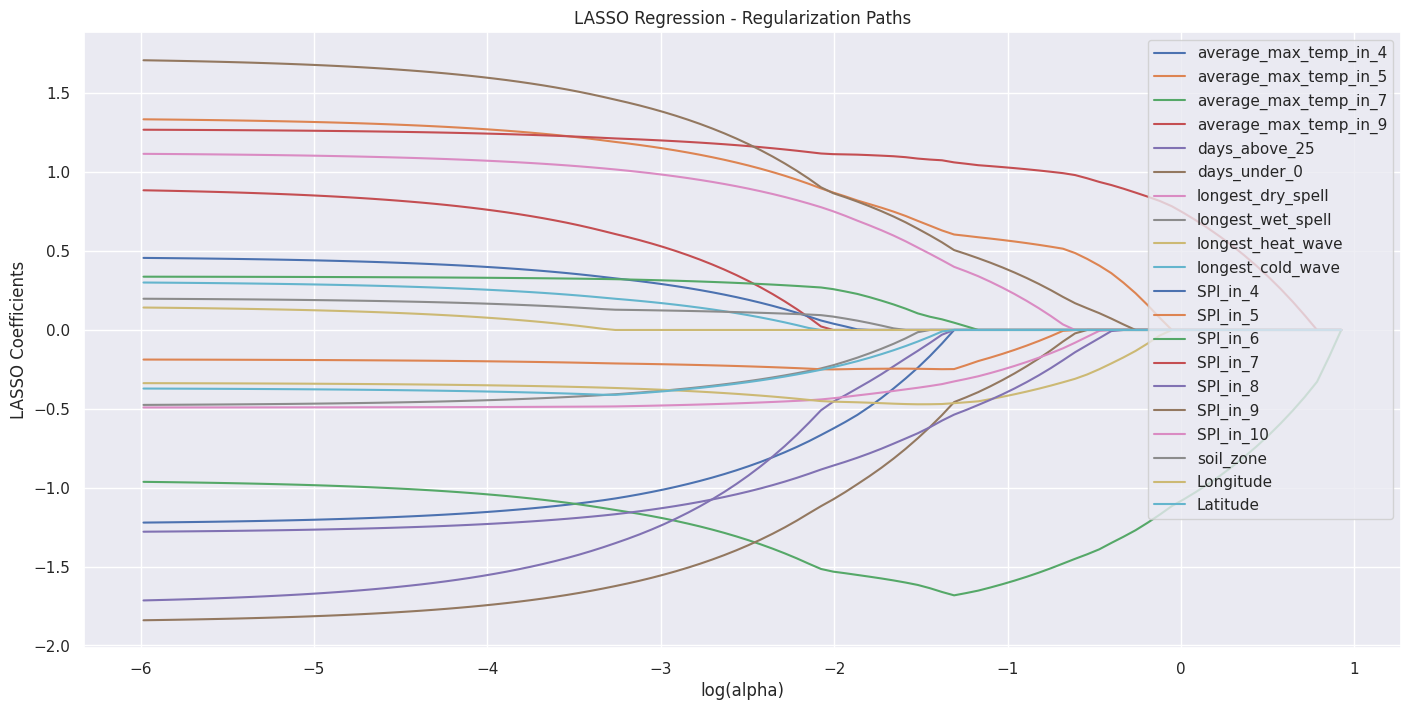

In [30]:
alphas, coefs_lasso, _ = LassoCV(alphas=np.logspace(-6, 8, 13)).path(X_train_scaled, y_train)

plt.figure(figsize=(17, 8))
lines = plt.plot(np.log(alphas), coefs_lasso.T)
plt.xlabel('log(alpha)')
plt.ylabel('LASSO Coefficients')
plt.title('LASSO Regression - Regularization Paths')
plt.legend(lines, X.columns, loc='upper right')
plt.show()

In [31]:
model = LassoCV(cv=5, random_state=0, max_iter=10000)

model.fit(X_train_scaled, y_train)

lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_scaled, y_train)

Lasso(alpha=0.009490690068220698)

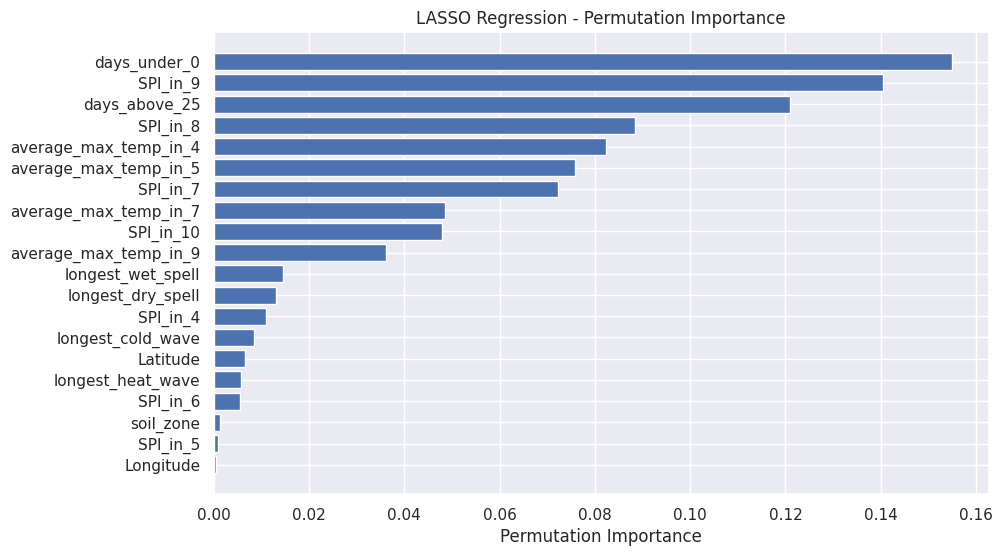

In [32]:
perm_importance = permutation_importance(lasso_best, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X.columns

# Plot permutation importance
plt.figure(figsize=(10, 6))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('LASSO Regression - Permutation Importance')
plt.show()

#### SVM

In [33]:
svm_regressor = SVR(kernel='rbf', C=1.0, gamma='scale')

In [34]:
svm_regressor.fit(X_train_scaled, y_train)

SVR()

In [35]:
y_pred = svm_regressor.predict(X_test_scaled)

In [36]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 12.89
R-squared: 0.67


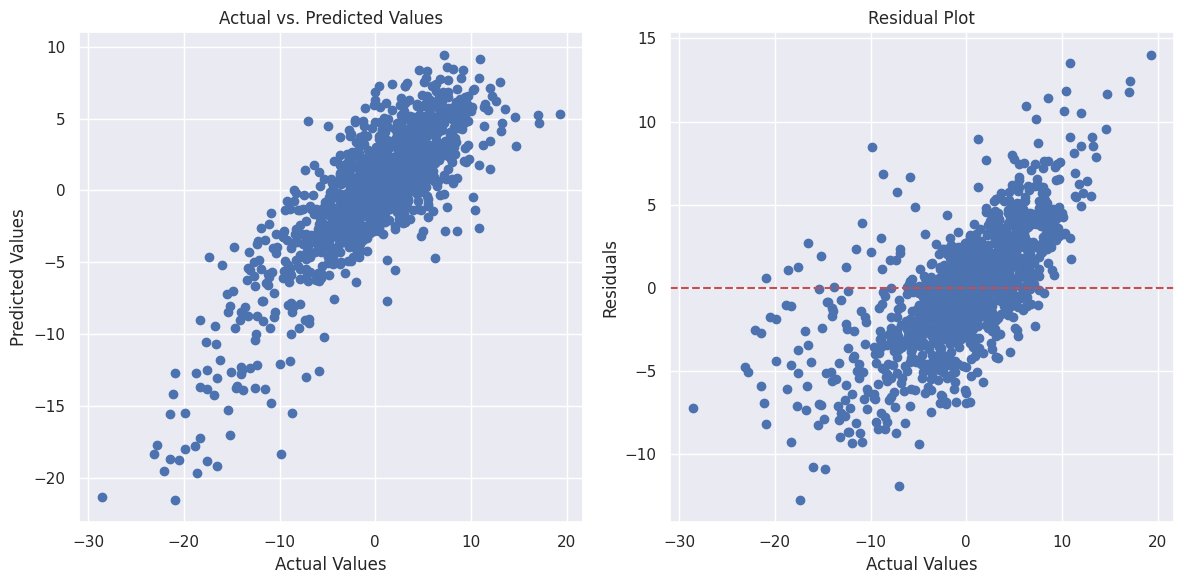

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

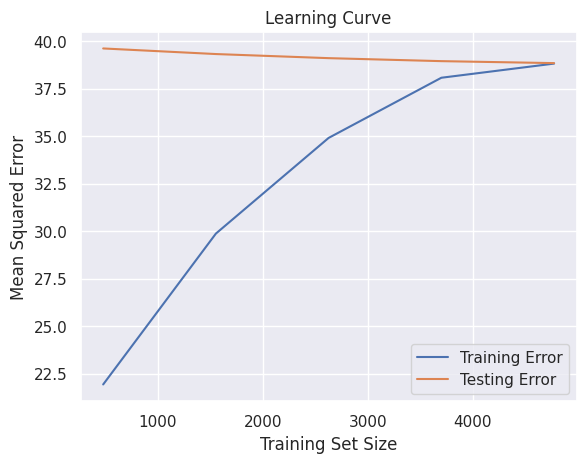

In [38]:
train_sizes, train_scores, test_scores = learning_curve(svm_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Error')
plt.plot(train_sizes, test_scores_mean, label='Testing Error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

#### Random Forest Regression

In [39]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest - Mean Squared Error: {mse:.2f}")
print(f"Random Forest - R-squared: {r2:.2f}")

Random Forest - Mean Squared Error: 10.16
Random Forest - R-squared: 0.74


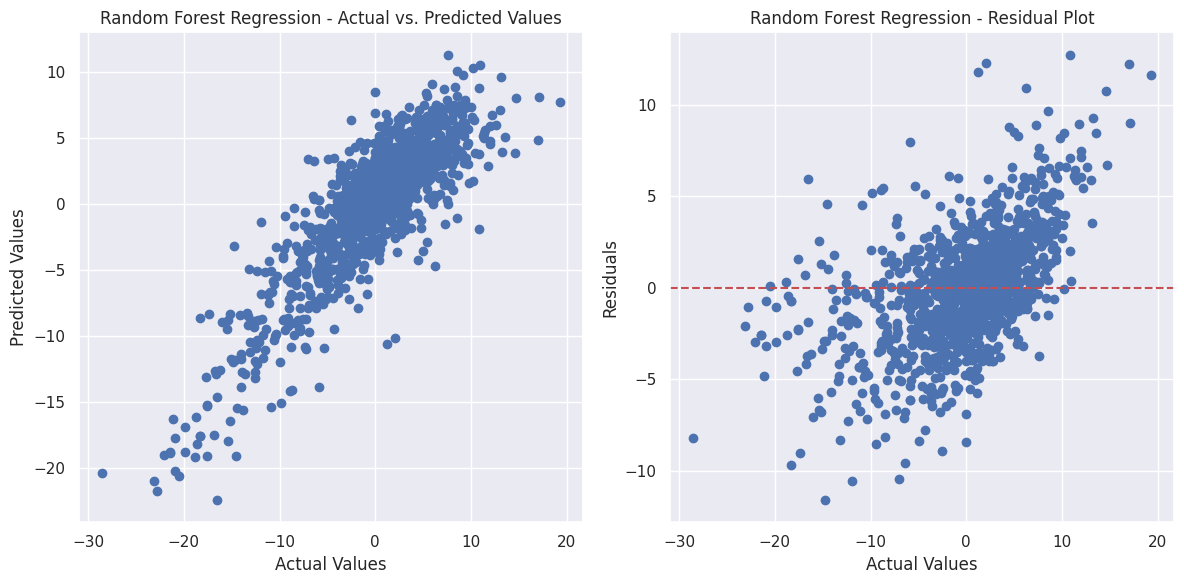

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression - Actual vs. Predicted Values')

plt.subplot(1, 2, 2)
residuals_rf = y_test - y_pred
plt.scatter(y_test, residuals_rf)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Random Forest Regression - Residual Plot')

plt.tight_layout()
plt.show()


Variable Importance:
                  Feature  Importance
2   average_max_temp_in_7    0.237474
12               SPI_in_6    0.072010
11               SPI_in_5    0.068159
5            days_under_0    0.059162
16              SPI_in_10    0.057547
0   average_max_temp_in_4    0.053979
3   average_max_temp_in_9    0.050189
14               SPI_in_8    0.047486
13               SPI_in_7    0.045344
10               SPI_in_4    0.041573
4           days_above_25    0.040744
18              Longitude    0.040306
15               SPI_in_9    0.039589
1   average_max_temp_in_5    0.039317
19               Latitude    0.033497
9       longest_cold_wave    0.023015
8       longest_heat_wave    0.021831
7       longest_wet_spell    0.013253
6       longest_dry_spell    0.012849
17              soil_zone    0.002676


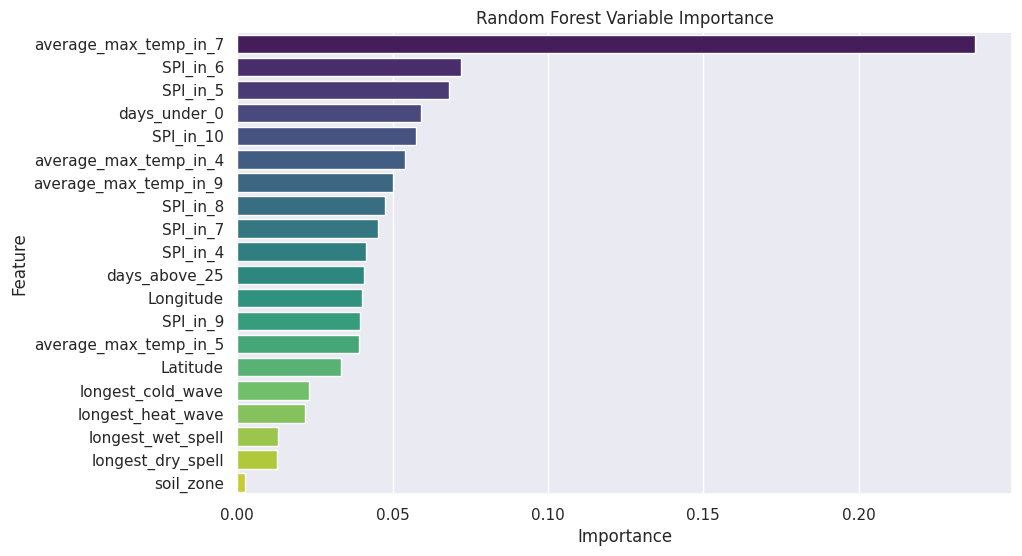

In [41]:
feature_importance = rf_regressor.feature_importances_
feature_names = X.columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


print("\nVariable Importance:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Permutation Importance:
                  Feature  Importance_Mean  Importance_Std
2   average_max_temp_in_7         0.403010        0.010031
11               SPI_in_5         0.218864        0.004706
5            days_under_0         0.195338        0.005625
13               SPI_in_7         0.094717        0.004611
12               SPI_in_6         0.086185        0.002157
3   average_max_temp_in_9         0.076708        0.001787
0   average_max_temp_in_4         0.074251        0.001863
4           days_above_25         0.063684        0.001650
14               SPI_in_8         0.059531        0.001849
16              SPI_in_10         0.058663        0.001741
10               SPI_in_4         0.051512        0.001338
18              Longitude         0.048552        0.001025
1   average_max_temp_in_5         0.043966        0.001329
15               SPI_in_9         0.042770        0.001086
19               Latitude         0.032616        0.000732
9       longest_cold_wave      

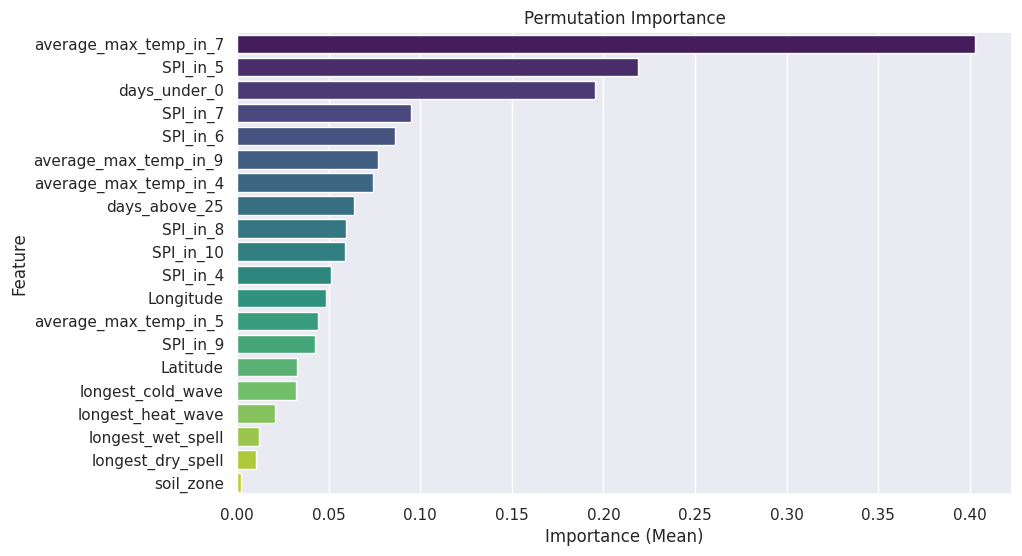

In [42]:
perm_importance = permutation_importance(rf_regressor, X, y, n_repeats=30, random_state=42)

perm_importance_mean = perm_importance.importances_mean
perm_importance_std = perm_importance.importances_std

perm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance_Mean': perm_importance_mean, 'Importance_Std': perm_importance_std})

perm_importance_df = perm_importance_df.sort_values(by='Importance_Mean', ascending=False)

print("\nPermutation Importance:")
print(perm_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance_Mean', y='Feature', data=perm_importance_df, palette='viridis')
plt.title('Permutation Importance')
plt.xlabel('Importance (Mean)')
plt.ylabel('Feature')
plt.show()

#### LSTM

In [43]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_lstm, y_train, epochs=80, batch_size=16, verbose=1)

y_pred_lstm = model.predict(X_test_lstm).flatten()

mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
print(f"LSTM - Mean Squared Error: {mse_lstm:.2f}")
print(f"LSTM - R-squared: {r2_lstm:.2f}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 36.0222
Epoch 2/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.7001
Epoch 3/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.4282
Epoch 4/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.9289
Epoch 5/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.4072
Epoch 6/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.7512
Epoch 7/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.6070
Epoch 8/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.1266
Epoch 9/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.3488
Epoch 10/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.0619
Epoch 11/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.4631
Epoch 12/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.5327
Epoch 13/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.0045
Epoch 14/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.9439
Epoch 15/80
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s

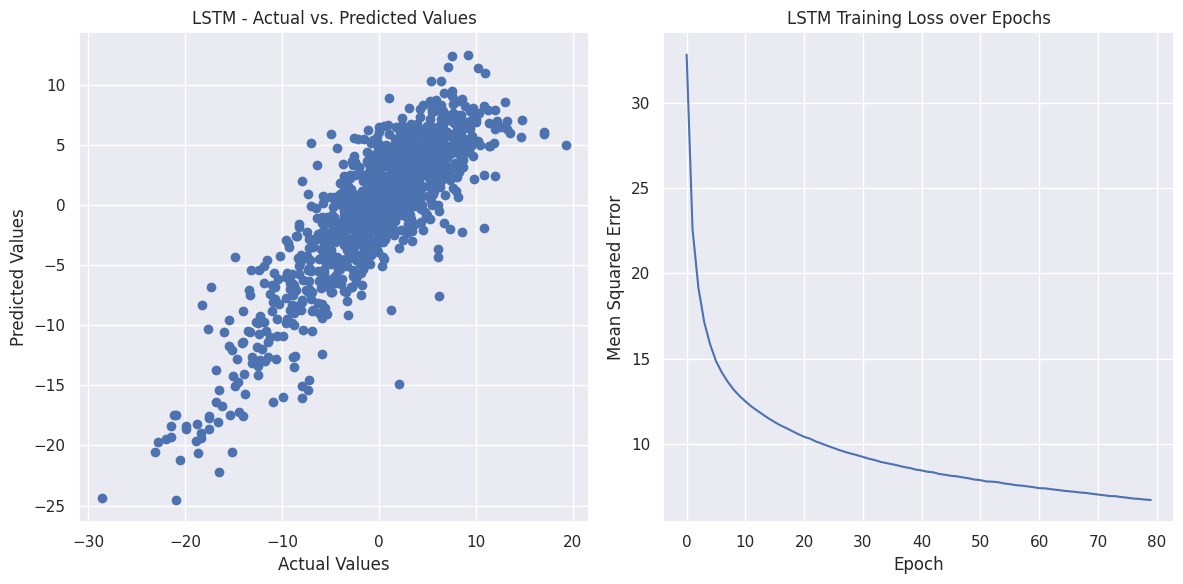

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lstm)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LSTM - Actual vs. Predicted Values')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('LSTM Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

## Approach 2: PCA and Modelling

In [45]:
canola_subsubset_exc = canola_subsubset.drop(columns=['Canola'])
standard_scaler = StandardScaler()
canola_scaled = standard_scaler.fit_transform(canola_subsubset_exc)

In [46]:
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(canola_scaled)

PCA(random_state=42, svd_solver='randomized')

In [47]:
pca.components_

array([[-3.02926302e-02,  2.71381937e-01,  4.09038676e-01,
         3.07371528e-01,  4.87539252e-01,  5.23517611e-02,
         6.52095690e-02, -2.71875375e-01,  2.26724908e-01,
        -3.53742008e-02, -7.96758723e-02, -2.09537781e-01,
        -2.37849369e-01, -2.86313905e-01, -2.06994995e-01,
        -1.31272007e-01,  1.23581016e-02,  1.58302931e-01,
        -1.22782401e-02, -1.34685513e-01],
       [-4.91431626e-01, -1.10517266e-02, -1.15086671e-01,
        -2.05910858e-01, -7.00127017e-02,  5.13016748e-01,
        -1.15061745e-01, -1.16291274e-01,  1.86249042e-01,
         3.81552622e-01,  1.40590941e-01, -2.23027375e-01,
        -2.22680924e-01, -3.25724304e-02, -1.23163727e-01,
         9.58351018e-02, -2.22903647e-02, -2.39000352e-01,
         7.80224778e-02,  1.39257568e-01],
       [ 2.21057380e-01,  3.14716123e-01, -3.51324972e-02,
        -2.74902571e-01, -1.22325067e-02, -5.20302869e-02,
         9.78519594e-02, -3.99917938e-02, -3.65779651e-02,
         1.23879788e-01, -2.2

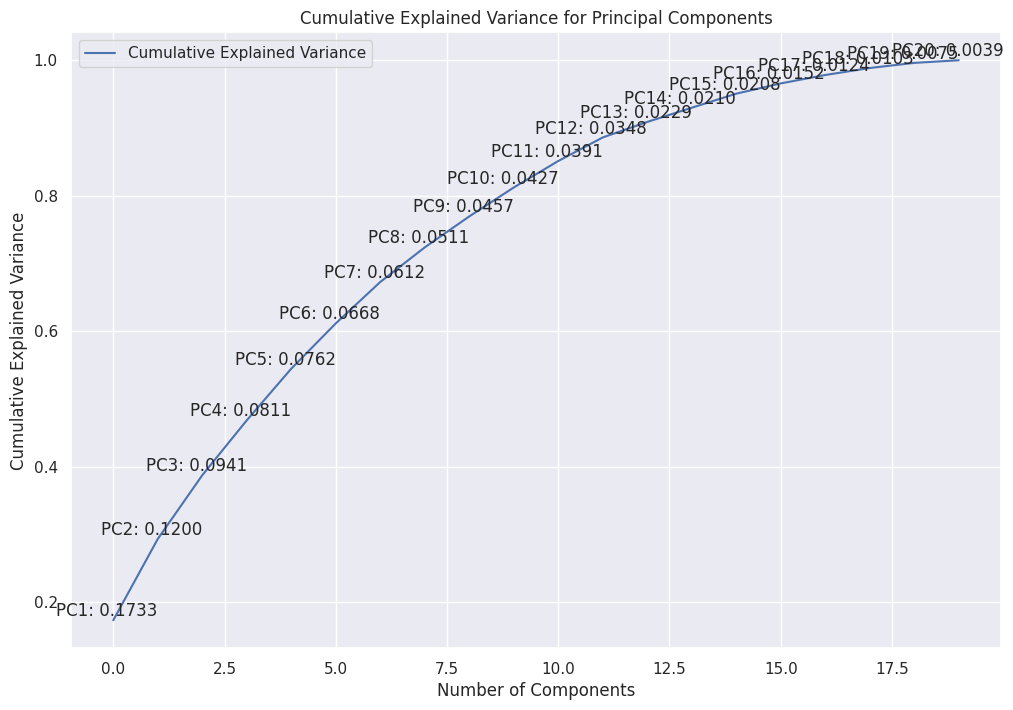

In [48]:
fig = plt.figure(figsize=(12, 8))
explained_variance_ratios = pca.explained_variance_ratio_

plt.plot(np.cumsum(explained_variance_ratios), label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for Principal Components')

for i, ratio in enumerate(explained_variance_ratios):
    plt.text(i + 1, np.cumsum(explained_variance_ratios)[i], f'PC{i + 1}: {ratio:.4f}', ha='right', va='bottom')

plt.legend()
plt.show()

In [49]:
colnames = list(canola_subsubset_exc.columns)

pcs_df = pd.DataFrame({'Feature': colnames,
                       'PC1': pca.components_[0],
                       'PC2': pca.components_[1],
                       'PC3': pca.components_[2],
                       'PC4': pca.components_[3],
                       'PC5': pca.components_[4],
                       'PC6': pca.components_[5],
                       'PC7': pca.components_[6],
                       'PC8': pca.components_[7],
                       'PC9': pca.components_[8],
                       'PC10': pca.components_[9]})

pcs_df

Feature       PC1       PC2       PC3       PC4       PC5  \
0   average_max_temp_in_4 -0.030293 -0.491432  0.221057  0.163814 -0.154718   
1   average_max_temp_in_5  0.271382 -0.011052  0.314716  0.340195  0.124695   
2   average_max_temp_in_7  0.409039 -0.115087 -0.035132 -0.081893 -0.151531   
3   average_max_temp_in_9  0.307372 -0.205911 -0.274903 -0.071181  0.377148   
4           days_above_25  0.487539 -0.070013 -0.012233  0.036705 -0.031091   
5            days_under_0  0.052352  0.513017 -0.052030 -0.015857  0.134293   
6       longest_dry_spell  0.065210 -0.115062  0.097852 -0.384186 -0.072400   
7       longest_wet_spell -0.271875 -0.116291 -0.039992  0.189208  0.194906   
8       longest_heat_wave  0.226725  0.186249 -0.036578 -0.102794 -0.066227   
9       longest_cold_wave -0.035374  0.381553  0.123880  0.190774  0.258253   
10               SPI_in_4 -0.079676  0.140591 -0.228542 -0.390041 -0.135604   
11               SPI_in_5 -0.209538 -0.223027 -0.092281 -0.267725 -0.056307   
12               SPI_in_6 -0.237849 -0.222681 -0.156862 -0.020004  0.140654   
13               SPI_in_7 -0.286314 -0.032572  0.011281  0.169192  0.144139   
14               SPI_in_8 -0.206995 -0.123164 -0.108513  0.026316  0.104782   
15               SPI_in_9 -0.131272  0.095835  0.425038  0.220545 -0.387749   
16              SPI_in_10  0.012358 -0.022290 -0.106790  0.151004  0.487991   
17              soil_zone  0.158303 -0.239000  0.211254 -0.016589  0.226947   
18              Longitude -0.012278  0.078022 -0.509173  0.360706 -0.335631   
19               Latitude -0.134686  0.139258  0.389056 -0.397929  0.190430   

         PC6       PC7       PC8       PC9      PC10  
0   0.064289 -0.079828 -0.098340 -0.000482 -0.237225  
1  -0.083692  0.009164  0.235300  0.127061  0.192687  
2   0.288827 -0.202219  0.004530  0.058581 -0.007641  
3  -0.125998  0.049553  0.100859 -0.185216 -0.017825  
4   0.164825  0.046724  0.052074  0.123704 -0.083923  
5   0.335094  0.001622 -0.017753  0.098224 -0.094656  
6  -0.113783  0.274280 -0.092664  0.586431  0.088676  
7   0.095508 -0.172482  0.268744  0.498731  0.185532  
8  -0.107035 -0.259171 -0.354578  0.297058  0.083451  
9   0.254301  0.099531 -0.029948 -0.166420 -0.107659  
10  0.320380  0.245795  0.153908  0.073135  0.224582  
11  0.294370 -0.045633 -0.216872 -0.073873 -0.462461  
12  0.333166 -0.194630  0.466143  0.068153  0.043095  
13 -0.162828  0.565232 -0.163162  0.147542 -0.091832  
14  0.088283 -0.279404 -0.488039 -0.154177  0.617121  
15  0.317220 -0.054914 -0.086665  0.103980 -0.000632  
16  0.113682 -0.183048 -0.331534  0.335281 -0.314251  
17  0.378658  0.364969 -0.167333 -0.126807  0.246476  
18 -0.076344  0.000397 -0.022024  0.104806 -0.065104  
19 -0.233561 -0.313525  0.124842 -0.036287 -0.100980

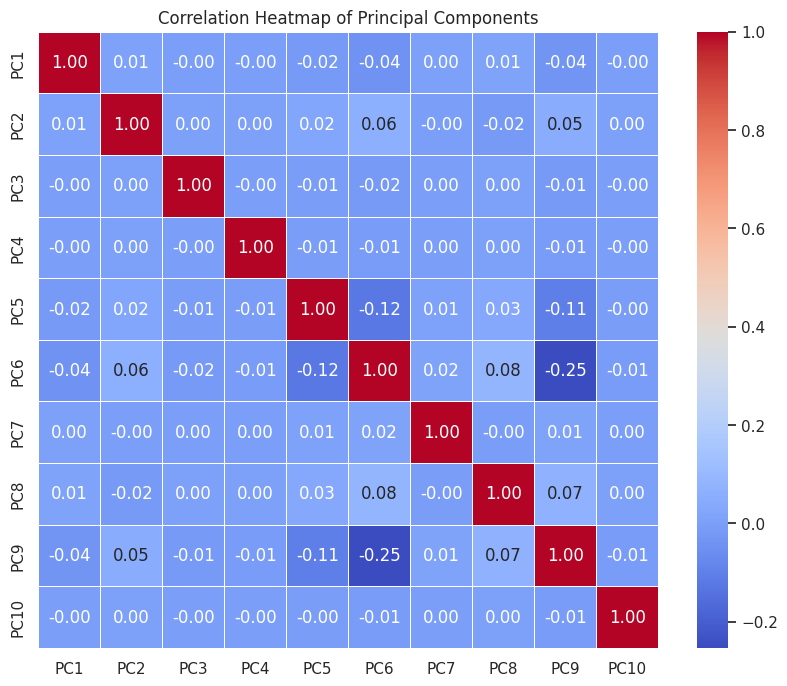

In [50]:
pcs = pcs_df.iloc[:, 1:]

correlation_matrix = pcs.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Principal Components')
plt.show()

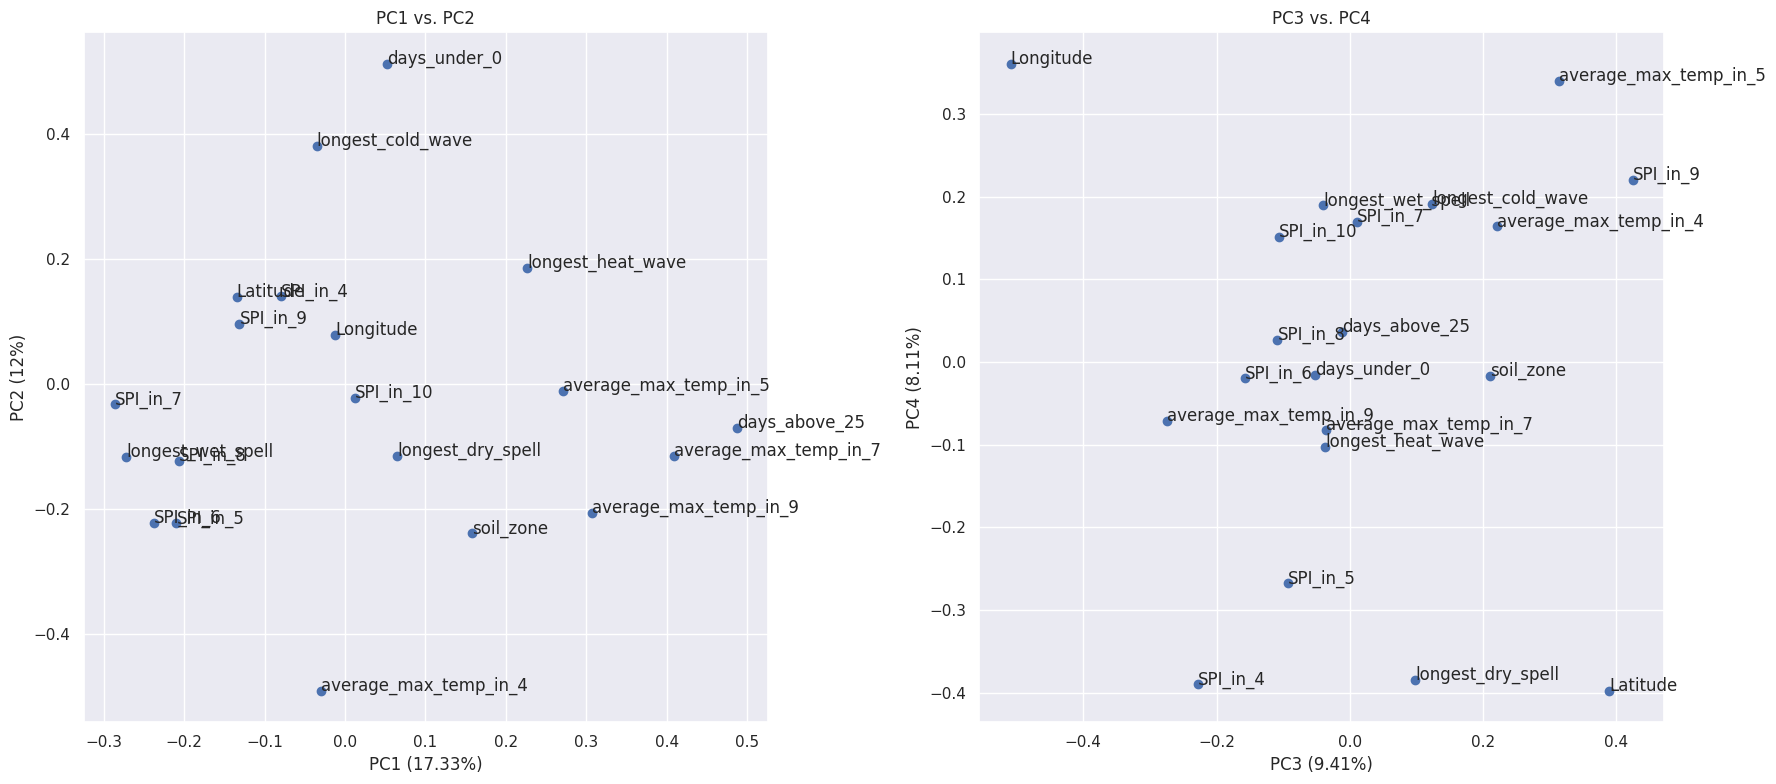

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.scatter(pcs_df.PC1, pcs_df.PC2)
ax1.set_xlabel('PC1 (17.33%)')
ax1.set_ylabel('PC2 (12%)')
for i, txt in enumerate(pcs_df.Feature):
    ax1.annotate(txt, (pcs_df.PC1[i], pcs_df.PC2[i]))
ax1.set_title('PC1 vs. PC2')

ax2.scatter(pcs_df.PC3, pcs_df.PC4)
ax2.set_xlabel('PC3 (9.41%)')
ax2.set_ylabel('PC4 (8.11%)')
for i, txt in enumerate(pcs_df.Feature):
    ax2.annotate(txt, (pcs_df.PC3[i], pcs_df.PC4[i]))
ax2.set_title('PC3 vs. PC4')

plt.tight_layout()
plt.show()

In [52]:
absolute_magnitude = np.abs(pca.components_)

squared_loading_scores = absolute_magnitude ** 2
normalized_loading_scores = squared_loading_scores / squared_loading_scores.sum(axis=0) * 100

variable_importance_df = pd.DataFrame({
    'Feature': colnames,
    'PC1': normalized_loading_scores[0],
    'PC2': normalized_loading_scores[1],
    'PC3': normalized_loading_scores[2],
    'PC4': normalized_loading_scores[3],
    'PC5': normalized_loading_scores[4],
    'PC6': normalized_loading_scores[5],
    'PC7': normalized_loading_scores[6],
    'PC8': normalized_loading_scores[7],
    'PC9': normalized_loading_scores[8],
    'PC10': normalized_loading_scores[9]
})

print(variable_importance_df)

                  Feature        PC1        PC2        PC3        PC4  \
0   average_max_temp_in_4   0.091764  24.150504   4.886637   2.683502   
1   average_max_temp_in_5   7.364816   0.012214   9.904624  11.573294   
2   average_max_temp_in_7  16.731264   1.324494   0.123429   0.670651   
3   average_max_temp_in_9   9.447726   4.239928   7.557142   0.506677   
4           days_above_25  23.769452   0.490178   0.014963   0.134727   
5            days_under_0   0.274071  26.318618   0.270715   0.025145   
6       longest_dry_spell   0.425229   1.323921   0.957501  14.759853   
7       longest_wet_spell   7.391622   1.352366   0.159934   3.579967   
8       longest_heat_wave   5.140418   3.468871   0.133795   1.056664   
9       longest_cold_wave   0.125133  14.558240   1.534620   3.639460   
10               SPI_in_4   0.634824   1.976581   5.223128  15.213196   
11               SPI_in_5   4.390608   4.974121   0.851586   7.167645   
12               SPI_in_6   5.657232   4.958679   2

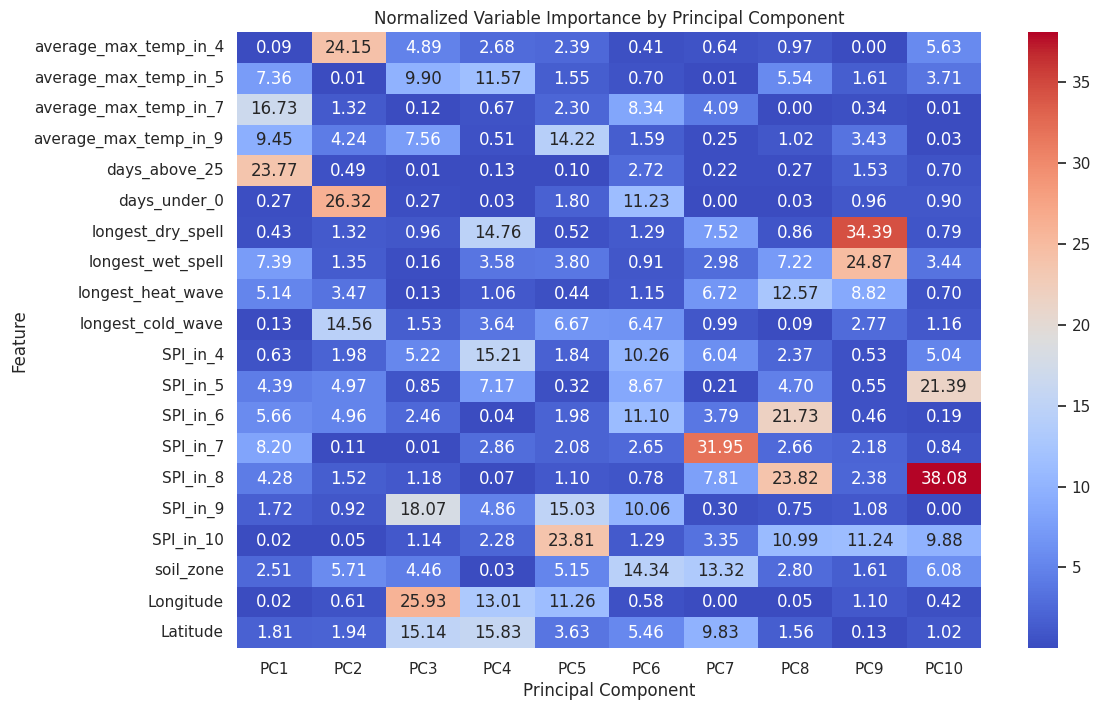

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(variable_importance_df.set_index('Feature'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Normalized Variable Importance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.yticks(rotation=0)
plt.show()

### Modelling

In [54]:
X = canola_features_no_outlier.drop(columns=['Canola', 'region_aggregate'])
y = canola_features_no_outlier['Canola']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

In [55]:
X_train_pcr, X_test_pcr, y_train_pcr, y_test_pcr = train_test_split(X_pca, y, test_size=0.2, random_state=42)

#### Linear Regression

In [56]:
pca_lr = LinearRegression()

pca_lr.fit(X_train_pcr, y_train_pcr)

predicted_train = pca_lr.predict(X_train_pcr)
predicted_test = pca_lr.predict(X_test_pcr)

r_squared_train = pca_lr.score(X_train_pcr, y_train_pcr)
r_squared_test = pca_lr.score(X_test_pcr, y_test_pcr)

mse_train = mean_squared_error(y_train_pcr, predicted_train)
mse_test = mean_squared_error(y_test_pcr, predicted_test)

print("Linear Regression - Training Set:")
print("Mean Squared Error (MSE):", mse_train)
print("R^2 Score:", r_squared_train)

print("\nLinear Regression - Test Set:")
print("Mean Squared Error (MSE):", mse_test)
print("R^2 Score:", r_squared_test)

Linear Regression - Training Set:
Mean Squared Error (MSE): 30.875242923896604
R^2 Score: 0.23492698149021096

Linear Regression - Test Set:
Mean Squared Error (MSE): 30.861185106066728
R^2 Score: 0.22088276093547876


#### Ridge

In [57]:
# alpha determination
alphas = [0.01, 0.02, 0.03, 0.05, 0.1, 1, 10]

PCA_ridge_cv = RidgeCV(alphas=alphas, cv=5)
PCA_ridge_cv.fit(X_train_pcr, y_train_pcr)

best_alpha = PCA_ridge_cv.alpha_

# modelling
PCA_ridge = Ridge(alpha=best_alpha)
PCA_ridge.fit(X_train_pcr, y_train_pcr)

predicted_canola_yield_PCA_ridge = PCA_ridge.predict(X_test_pcr)

print("Best alpha:", best_alpha)

mse_PCA_ridge = mean_squared_error(y_test_pcr, predicted_canola_yield_PCA_ridge)
print("Mean Squared Error (PCA Ridge Regression):", mse_PCA_ridge)

r_squared_PCA_ridge = PCA_ridge.score(X_test_pcr, y_test_pcr)
print("R^2 Score (PCA Ridge Regression):", r_squared_PCA_ridge)

# changes not impacting scores and same as LR, signs of no multicollinearity

Best alpha: 10.0
Mean Squared Error (PCA Ridge Regression): 30.860322262102954
R^2 Score (PCA Ridge Regression): 0.2209045441756392


#### LASSO Regression

In [58]:
lasso_model_1 = Lasso(alpha=0.1)  # Adjust alpha as needed
lasso_model_1.fit(X_train_pcr, y_train_pcr)

lasso_coefs_1 = lasso_model_1.coef_

y_pred_lasso_1 = lasso_model_1.predict(X_test_pcr)

mse_lasso_1 = mean_squared_error(y_test_pcr, y_pred_lasso_1)
r2_lasso_1 = r2_score(y_test_pcr, y_pred_lasso_1)

print(f"LASSO - Mean Squared Error: {mse_lasso_1:.2f}")
print(f"LASSO - R-squared: {r2_lasso_1:.2f}")

LASSO - Mean Squared Error: 30.86
LASSO - R-squared: 0.22


Mean Squared Error (MSE) (PCA Lasso): 30.855787008171806
R^2 Score (PCA Lasso): 0.22101904057327093


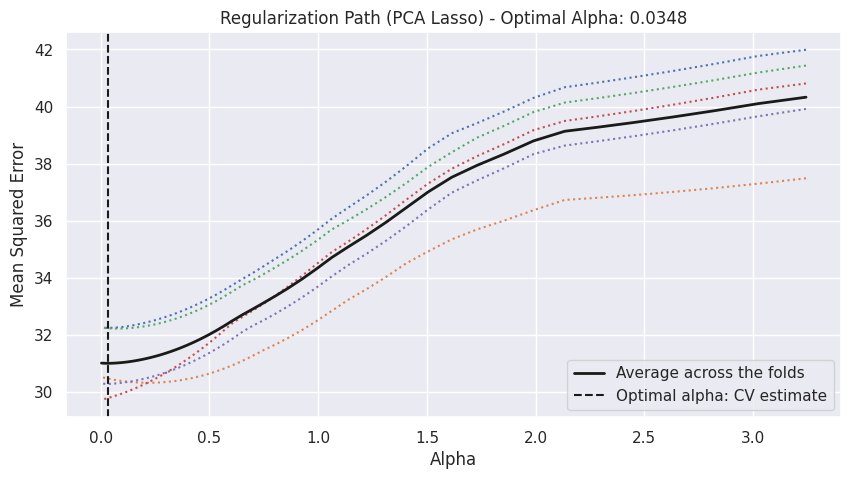

In [59]:
PCA_lasso = LassoCV(cv=5)

PCA_lasso.fit(X_train_pcr, y_train_pcr)

predicted_canola_yield_lasso = PCA_lasso.predict(X_test_pcr)

r_squared_lasso = PCA_lasso.score(X_test_pcr, y_test_pcr)
mse_lasso = mean_squared_error(y_test_pcr, predicted_canola_yield_lasso)

print("Mean Squared Error (MSE) (PCA Lasso):", mse_lasso)
print("R^2 Score (PCA Lasso):", r_squared_lasso)

plt.figure(figsize=(10, 5))
plt.plot(PCA_lasso.alphas_, PCA_lasso.mse_path_, ':')
plt.plot(PCA_lasso.alphas_, PCA_lasso.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(PCA_lasso.alpha_, linestyle='--', color='k',
            label='Optimal alpha: CV estimate')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title(f'Regularization Path (PCA Lasso) - Optimal Alpha: {PCA_lasso.alpha_:.4f}')
plt.show()

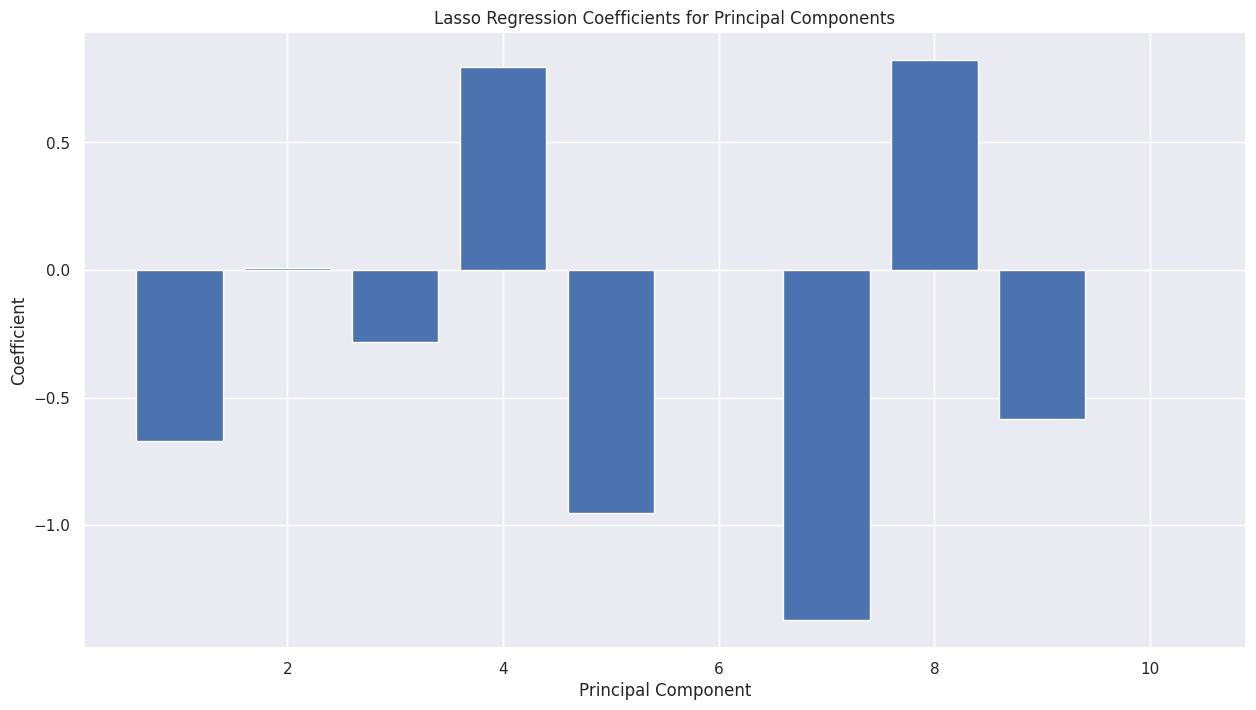

In [60]:
lasso_coefficients = PCA_lasso.coef_

plt.figure(figsize=(15, 8))
plt.bar(range(1, len(lasso_coefficients) + 1), lasso_coefficients)
plt.xlabel('Principal Component')
plt.ylabel('Coefficient')
plt.title('Lasso Regression Coefficients for Principal Components')
plt.show()

In [61]:
print(PCA_lasso.coef_)

[-0.67091845  0.00690368 -0.28214803  0.79442274 -0.95127525 -0.
 -1.37164706  0.82195702 -0.58243682 -0.        ]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242.86303924402455, tolerance: 24.015402352715167
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2608.8012980817, tolerance: 24.015402352715167
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6315.582867714518, tolerance: 24.015402352715167
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceW

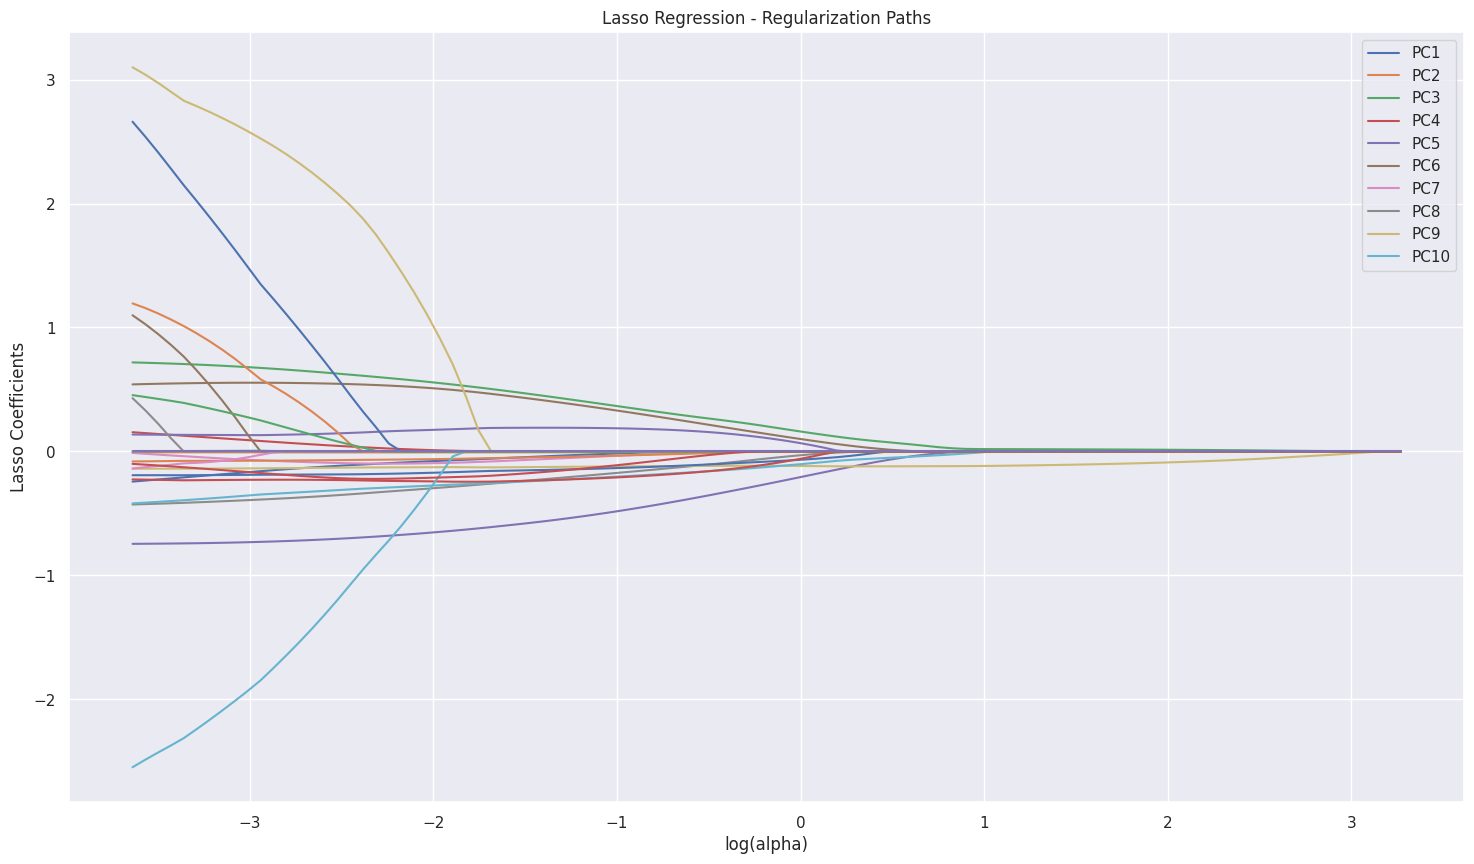

In [62]:
alphas, coefs_lasso, _ = PCA_lasso.path(X, y)

plt.figure(figsize=(18, 10))
plt.plot(np.log(alphas), coefs_lasso.T)
plt.xlabel('log(alpha)')
plt.ylabel('Lasso Coefficients')
plt.title('Lasso Regression - Regularization Paths')
plt.legend(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], loc='upper right')
plt.show()

#### SVR

In [63]:
svr_pcr = SVR(kernel='rbf') 

In [64]:
svr_pcr.fit(X_train_pcr, y_train_pcr)

y_pred_pcr = svr_pcr.predict(X_test_pcr)

mse_pcr = mean_squared_error(y_test_pcr, y_pred_pcr)
r2_pcr = r2_score(y_test_pcr, y_pred_pcr)

print("R^2 Score (PCR):", r2_pcr)
print("Mean Squared Error (PCR):", mse_pcr)

R^2 Score (PCR): 0.6398105377687864
Mean Squared Error (PCR): 14.267266991189718


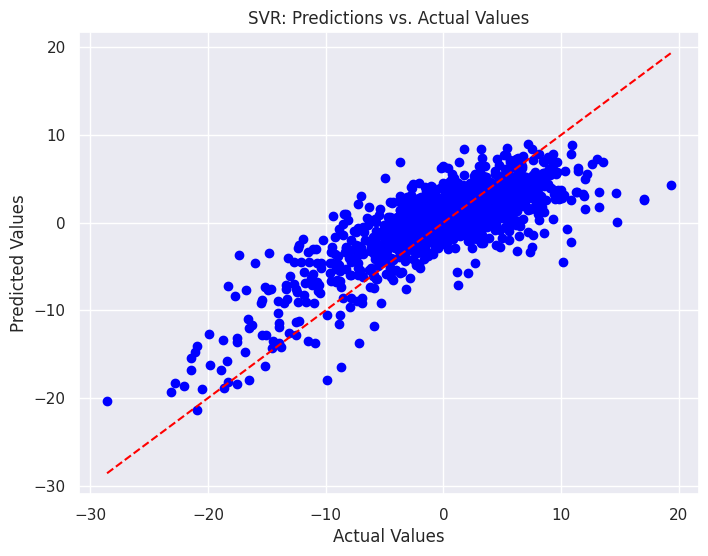

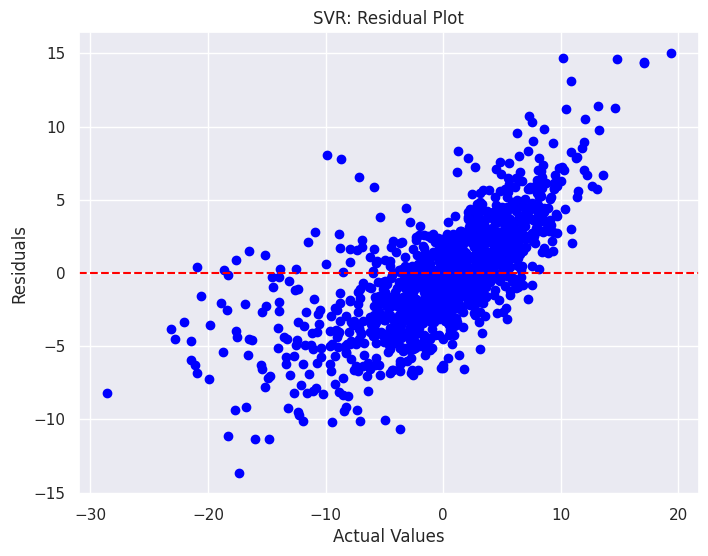

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pcr, y_pred_pcr, color='blue')
plt.plot([min(y_test_pcr), max(y_test_pcr)], [min(y_test_pcr), max(y_test_pcr)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR: Predictions vs. Actual Values')
plt.show()

residuals = y_test_pcr - y_pred_pcr
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pcr, residuals, color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('SVR: Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [66]:
param_grid = {
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'C': [0.1, 1, 10, 100, 1000]
}

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_pcr, y_train_pcr)

best_params = grid_search.best_params_
best_gamma = best_params['gamma']
best_C = best_params['C']

print("Best gamma:", best_gamma)
print("Best C:", best_C)

best_model = SVR(gamma=best_gamma, C=best_C)
best_model.fit(X_train_pcr, y_train_pcr)

r_squared = best_model.score(X_test_pcr, y_test_pcr)
print("R^2 Score:", r_squared)

Best gamma: 0.1
Best C: 10
R^2 Score: 0.7236014741998198


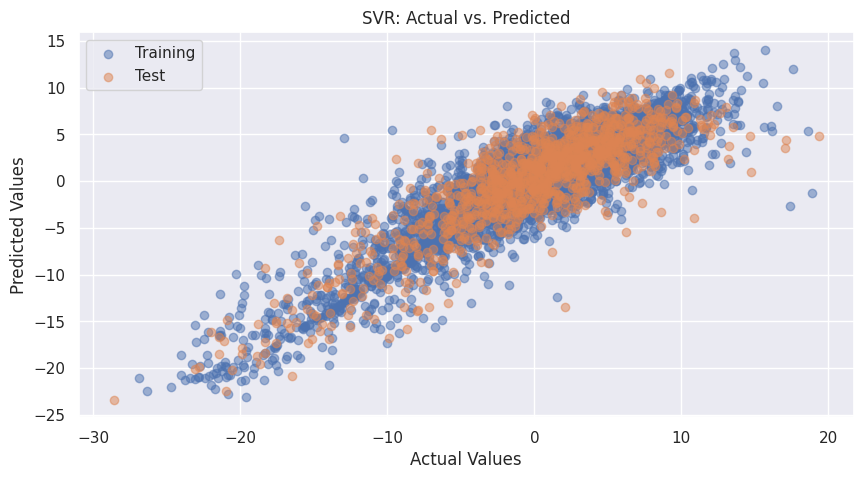

In [67]:
train_predictions = best_model.predict(X_train_pcr)
test_predictions = best_model.predict(X_test_pcr)

plt.figure(figsize=(10, 5))
plt.scatter(y_train_pcr, train_predictions, label='Training', alpha=0.5)
plt.scatter(y_test_pcr, test_predictions, label='Test', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR: Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

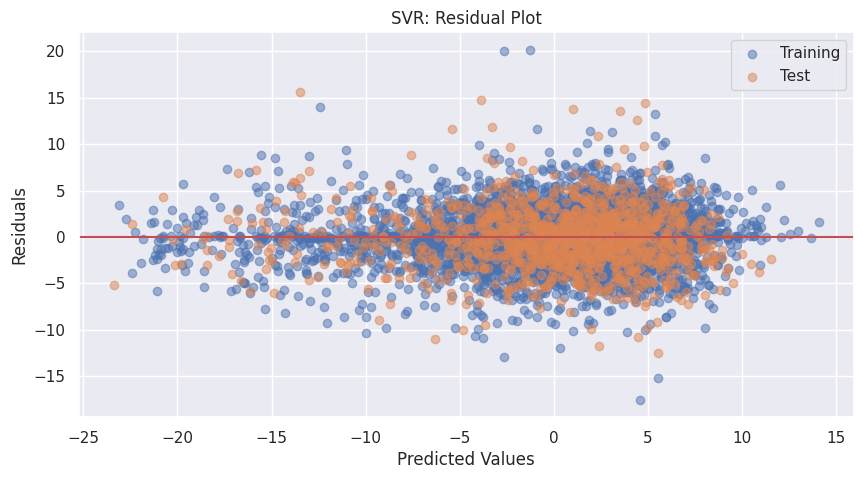

In [68]:
train_residuals = y_train_pcr - train_predictions
test_residuals = y_test_pcr - test_predictions

plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, label='Training', alpha=0.5)
plt.scatter(test_predictions, test_residuals, label='Test', alpha=0.5)

plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('SVR: Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
mse_pcr_cv = mean_squared_error(y_test_pcr, test_predictions)
mse_pcr_cv

10.948270221828482

In [70]:
rfr = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 3, 5, 7, 10],        # Maximum depth of the trees
    'min_samples_leaf': [2, 5, 10, 30],
    'max_samples': [0.7, 0.9, 1]
}

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_pcr, y_train_pcr)

best_rfr = grid_search.best_estimator_

best_rfr.fit(X_train_pcr, y_train_pcr)

y_pred_test = best_rfr.predict(X_test_pcr)

r_squared = best_rfr.score(X_test_pcr, y_test_pcr)
mse = mean_squared_error(y_test_pcr, y_pred_test)
print("R^2 Score:", r_squared)
print("Mean Squared Error:", mse)

R^2 Score: 0.7103910740023185
Mean Squared Error: 11.4715401295895


In [71]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'max_samples': 0.9, 'min_samples_leaf': 2, 'n_estimators': 300}


In [72]:
# max_depth None: flexibility might indicate that the relationships in data are complex and require deep trees to capture them accurately (go for 7-8 instead)
# min_samples_leaf 1, min_samples_split:  relatively low values (1 and 2, respectively), indicating that the model is allowed to split nodes even if they contain very few samples. This can lead to more complex and detailed trees, potentially capturing intricate patterns in your data. However, it also increases the risk of overfitting, especially if the dataset is noisy or contains outliers.
# 300 trees suggests that the model is leveraging a large ensemble of decision trees to make predictions. A higher number of trees can lead to better generalization performance by reducing variance, although it also increases computational cost

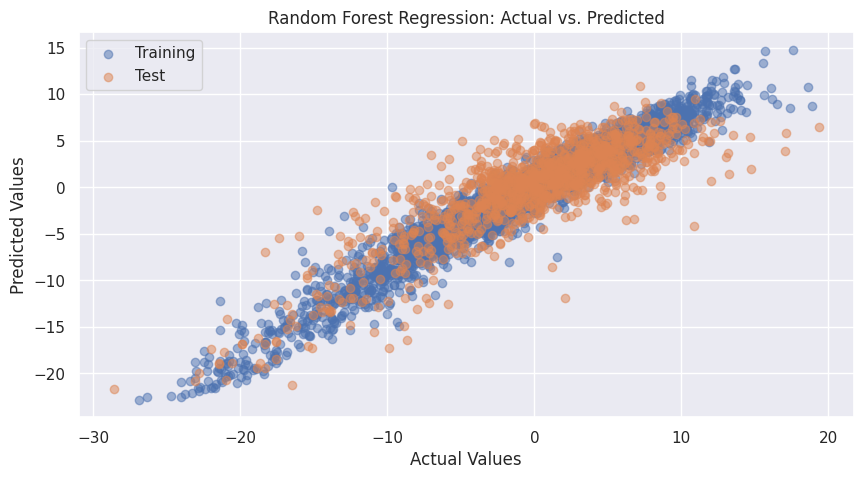

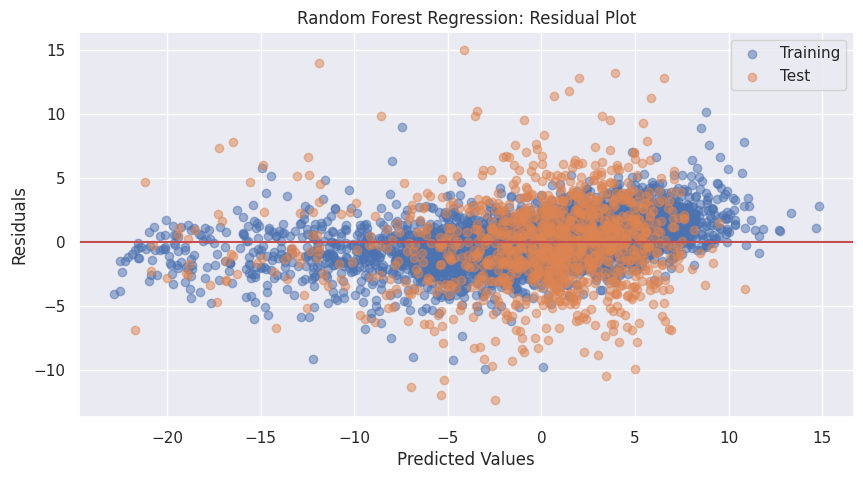

In [73]:
train_predictions_rf = best_rfr.predict(X_train_pcr)
test_predictions_rf = best_rfr.predict(X_test_pcr)

plt.figure(figsize=(10, 5))

plt.scatter(y_train_pcr, train_predictions_rf, label='Training', alpha=0.5)

plt.scatter(y_test_pcr, test_predictions_rf, label='Test', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression: Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

train_residuals_rf = y_train_pcr - train_predictions_rf
test_residuals_rf = y_test_pcr - test_predictions_rf

plt.figure(figsize=(10, 5))
plt.scatter(train_predictions_rf, train_residuals_rf, label='Training', alpha=0.5)
plt.scatter(test_predictions_rf, test_residuals_rf, label='Test', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Random Forest Regression: Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

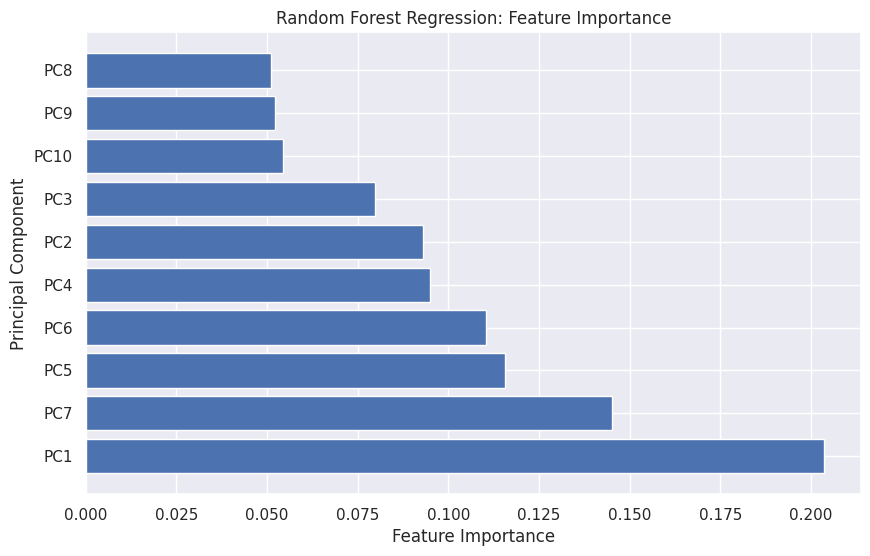

In [74]:
feature_importances = best_rfr.feature_importances_

pc_labels = ['PC{}'.format(i) for i in range(1, len(feature_importances) + 1)]

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = np.array(pc_labels)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Principal Component')
plt.title('Random Forest Regression: Feature Importance')
plt.show()

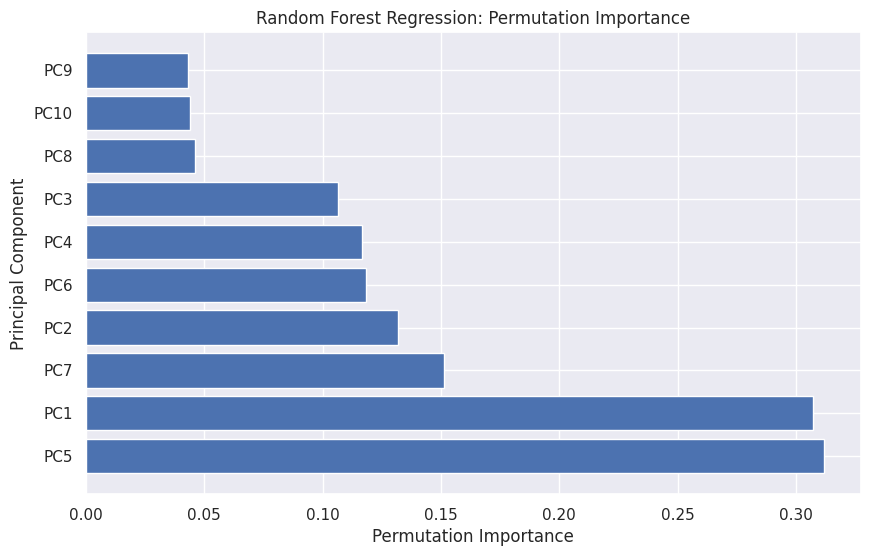

In [75]:
best_rfr.fit(X_train_pcr, y_train_pcr)

result_rfr = permutation_importance(best_rfr, X_test_pcr, y_test_pcr, n_repeats=10, random_state=42)

sorted_indices = np.argsort(result_rfr.importances_mean)[::-1]
sorted_feature_importances = result_rfr.importances_mean[sorted_indices]
sorted_features = np.array(pc_labels)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_feature_importances)
plt.xlabel('Permutation Importance')
plt.ylabel('Principal Component')
plt.title('Random Forest Regression: Permutation Importance')
plt.show()

#### LSTM

In [76]:
lstm_model = Sequential([
    LSTM(units=50, input_shape=(X_train_pcr.shape[1], 1)),  # Assuming each sequence has one feature
    Dense(units=1)  # Output layer
])

lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

lstm_history = lstm_model.fit(X_train_pcr, y_train_pcr, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

lstm_loss = lstm_model.evaluate(X_test_pcr, y_test_pcr)
print("Test Loss:", lstm_loss)

min_val_loss_epoch = np.argmin(lstm_history.history['val_loss'])
min_val_loss = lstm_history.history['val_loss'][min_val_loss_epoch]

print("Lowest validation loss occurred at epoch:", min_val_loss_epoch)
print("Lowest validation loss:", min_val_loss)

y_pred_test = lstm_model.predict(X_test_pcr)

r_squared = r2_score(y_test_pcr, y_pred_test)
print("R^2 Score:", r_squared)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 39.2279 - val_loss: 34.4633
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.6535 - val_loss: 34.5798
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.8617 - val_loss: 34.3074
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.9922 - val_loss: 34.0654
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.7547 - val_loss: 34.6022
Epoch 6/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.0390 - val_loss: 34.3362
Epoch 7/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.8776 - val_loss: 33.3756
Epoch 8/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.6302 - val_loss: 32.7605
Epoch 9/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.2602 - val_loss: 32.0072
Epoch 10/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.9250 - val_loss: 31.2424
Epoch 11/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.8080 - val_loss: 31.0098
Epoch 12/200
120/120 ━━━━━━━━━━

In [77]:
y_pred = lstm_model.predict(X_test_pcr)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model_2 = Sequential([
    LSTM(units=50, input_shape=(X_train_pcr.shape[1], 1)), 
    Dense(units=1)
])

lstm_model_2.compile(optimizer=Adam(), loss='mean_squared_error')

lstm_history = lstm_model_2.fit(X_train_pcr, y_train_pcr, epochs=200, batch_size=32, 
                               validation_split=0.2, verbose=1, callbacks=[early_stopping])

lstm_loss = lstm_model_2.evaluate(X_test_pcr, y_test_pcr)
print("Test Loss:", lstm_loss)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 38.6082 - val_loss: 34.7893
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.3412 - val_loss: 34.5887
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.3631 - val_loss: 34.1095
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.3440 - val_loss: 34.0800
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.8602 - val_loss: 33.7772
Epoch 6/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.9155 - val_loss: 34.8757
Epoch 7/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.0427 - val_loss: 33.5768
Epoch 8/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.9805 - val_loss: 32.4842
Epoch 9/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.7746 - val_loss: 31.6313
Epoch 10/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.9712 - val_loss: 31.5246
Epoch 11/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.9817 - val_loss: 31.4120
Epoch 12/200
120/120 ━━━━━━━━━━

In [79]:
y_pred_2 = lstm_model_2.predict(X_test_pcr)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


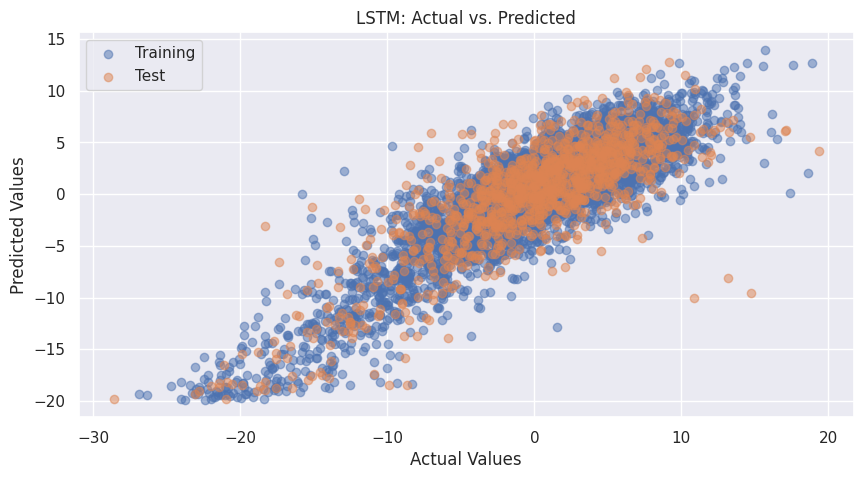

In [80]:
train_predictions_lstm = lstm_model_2.predict(X_train_pcr)
test_predictions_lstm = lstm_model_2.predict(X_test_pcr)

plt.figure(figsize=(10, 5))
plt.scatter(y_train_pcr, train_predictions_lstm, label='Training', alpha=0.5)
plt.scatter(y_test_pcr, test_predictions_lstm, label='Test', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LSTM: Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


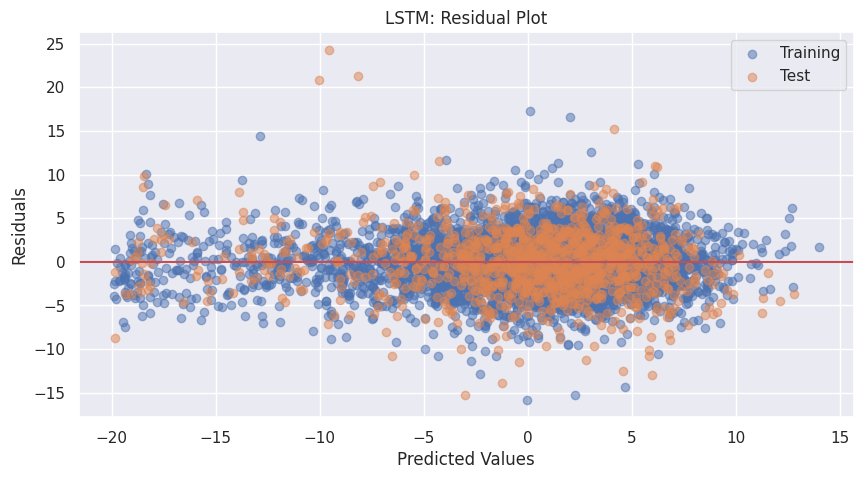

In [81]:
train_predictions_lstm = lstm_model_2.predict(X_train_pcr).flatten()
test_predictions_lstm = lstm_model_2.predict(X_test_pcr).flatten()

train_residuals_lstm = y_train_pcr - train_predictions_lstm
test_residuals_lstm = y_test_pcr - test_predictions_lstm


plt.figure(figsize=(10, 5))
plt.scatter(train_predictions_lstm, train_residuals_lstm, label='Training', alpha=0.5)
plt.scatter(test_predictions_lstm, test_residuals_lstm, label='Test', alpha=0.5)

plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('LSTM: Residual Plot')
plt.legend()
plt.grid(True)
plt.show()